# Long Short Term Memory (LSTM) Implementation

In [1]:
## Imports

import numpy as np  
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf 
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf # tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, MaxPooling2D,Activation,AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# Loading the Data

In [2]:
## Data Load

CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []   # filename/details
list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(".", topdown=False):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('\\')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('\\'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file), sep=',',header=None)
                list_of_img.append(df.values)

x = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

17485 files loaded.


# Example Person Sample

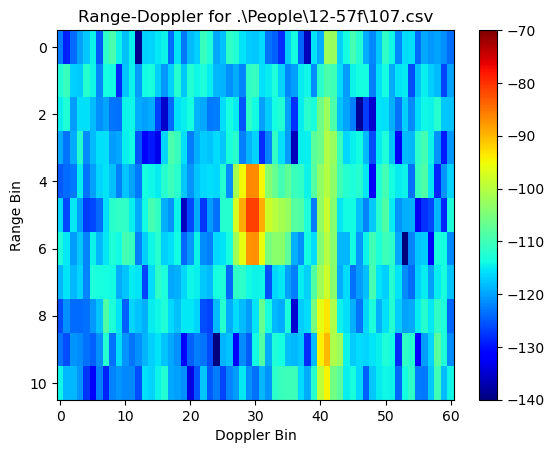

In [3]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[16300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[16299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Drone Sample

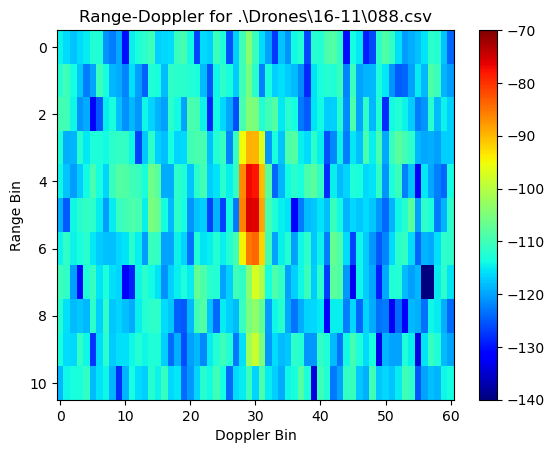

In [4]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[10300], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[10299]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Example Car Sample

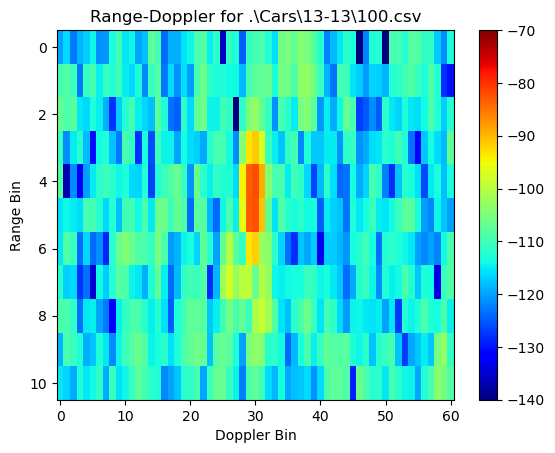

In [5]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[100], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[99]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

# Data Preprocessing

In [6]:
#Preprocessing the Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train_original, x_test_original, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=31, shuffle=True)

x_train_original_shape = x_train_original.shape

# Reshape the data to 2D
x_train_reshaped = x_train_original.reshape(x_train_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_reshaped)

# Reshape the data back to its original shape
x_train = x_train_scaled.reshape(x_train_original_shape)

# X_test scaling 
x_test_original_shape = x_test_original.shape

# Reshape the data to 2D
x_test_reshaped = x_test_original.reshape(x_test_original.shape[0], -1)

# Create and fit the StandardScaler
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test_reshaped)

# Reshape the data back to its original shape
x_test = x_test_scaled.reshape(x_test_original_shape)

# Defining the Utility Functions to Plot Accuracies and Losses

In [7]:
##Defining utility functions to plot Accuracies and Losses

def smooth_curve(points,factor = 0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)

  return smoothed_points

def plot_convergence():
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.plot(smooth_curve(history.history['accuracy']), marker= 'o', label = 'Train Accuracy')
  plt.plot(smooth_curve(history.history['val_accuracy']), marker= 'o', label = 'Validation Accuracy')
  plt.title('Training and Validation Accuracy over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(smooth_curve(history.history['loss']),marker = 'o', label = 'Train Loss')
  plt.plot(smooth_curve(history.history['val_loss']),marker = 'o', label = 'Validation Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

def test_model_accuracy(model):
  test_loss,test_accuracy = model.evaluate(x_test_lstm, y_test_lstm)
  print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
  plot_convergence()

# Reshaping the Data for Feeding the LSTM

In [8]:
import numpy as np

def reshape_for_lstm(X, y, time_steps):
    # Get the original shape
    samples, height, width = X.shape
    
    # Reshape X to (samples, time_steps, features)
    X_reshaped = X.reshape(samples, time_steps, height * width // time_steps)
    
    # Convert y to one-hot encoded format
    y_onehot = np.eye(np.max(y) + 1)[y]
    
    return X_reshaped, y_onehot

x_train_lstm, y_train_lstm = reshape_for_lstm(x_train, y_train, time_steps=11)
x_test_lstm, y_test_lstm = reshape_for_lstm(x_test, y_test, time_steps=11)

# LSTM Model Building

### One LSTM and One Output Layer for Classification

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                32256     
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 8s 13ms/step - loss: 0.3906 - accuracy: 0.8454 - val_loss: 0.2802 - val_accuracy: 0.8863
Epoch 2/30
350/350 [==============================] - 4s 11ms/step - loss: 0.2440 - accuracy: 0.8954 - val_loss: 0.2547 - val_accuracy: 0.8967
Epoch 3/30
350/350 [==============================] - 4s 11ms/step - loss: 0.2022 - accuracy: 0.9147 - val_loss: 0.2577 - val_accuracy: 0.8978
Epoch 4/30
350/350 [==============================] - 3s 10ms/step - loss: 0.1756 - accuracy: 0.9276 - val_loss: 0.2253 - val_accuracy: 0.9107
Epoch 5/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1463 - accuracy: 0.9405 - val_loss: 0.2261 - val_accuracy: 0.9124
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1211 - accuracy: 0.9526 - val_loss: 0.2173 - val_accuracy: 0.9164
Epoch 7/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1001 - accuracy: 0.9608 - val_loss: 0.2380 - val_accuracy: 0.9174

110/110 [==============================] - 1s 5ms/step - loss: 0.4777 - accuracy: 0.9248
Test Accuracy: 92.4793%


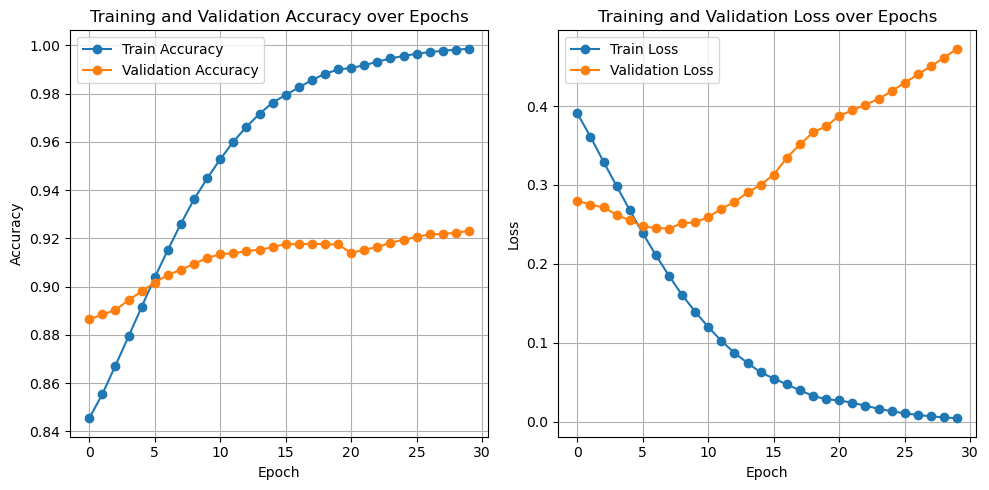

In [37]:
test_model_accuracy(model)

### One LSTM One Dense and One Output Layer for Classification

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                32256     
                                                                 
 dense_14 (Dense)            (None, 16)                1040      
                                                                 
 dense_15 (Dense)            (None, 3)                 51        
                                                                 
Total params: 33,347
Trainable params: 33,347
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 7s 12ms/step - loss: 0.4229 - accuracy: 0.8290 - val_loss: 0.2704 - val_accuracy: 0.8939
Epoch 2/30
350/350 [==============================] - 4s 11ms/step - loss: 0.2437 - accuracy: 0.8962 - val_loss: 0.2489 - val_accuracy: 0.9003
Epoch 3/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2028 - accuracy: 0.9130 - val_loss: 0.2282 - val_accuracy: 0.9099
Epoch 4/30
350/350 [==============================] - 4s 11ms/step - loss: 0.1672 - accuracy: 0.9315 - val_loss: 0.2322 - val_accuracy: 0.9117
Epoch 5/30
350/350 [==============================] - 4s 10ms/step - loss: 0.1410 - accuracy: 0.9413 - val_loss: 0.2267 - val_accuracy: 0.9146
Epoch 6/30
350/350 [==============================] - 4s 11ms/step - loss: 0.1186 - accuracy: 0.9534 - val_loss: 0.2279 - val_accuracy: 0.9146
Epoch 7/30
350/350 [==============================] - 5s 14ms/step - loss: 0.0952 - accuracy: 0.9641 - val_loss: 0.2485 - val_accuracy: 0.9192

110/110 [==============================] - 1s 6ms/step - loss: 0.5589 - accuracy: 0.9242
Test Accuracy: 92.4221%


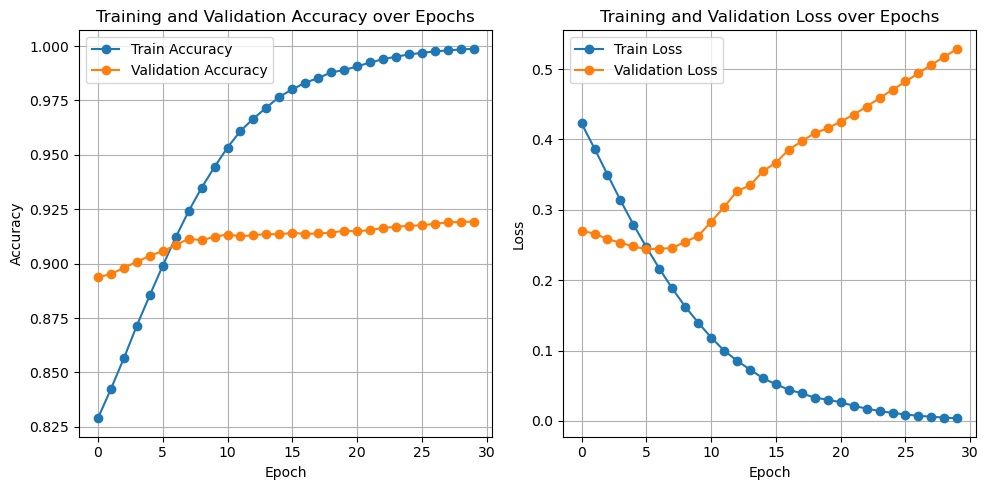

In [46]:
test_model_accuracy(model)

### One LSTM Two Dense and One Output Layer for Classification

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                32256     
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dense_17 (Dense)            (None, 16)                272       
                                                                 
 dense_18 (Dense)            (None, 3)                 51        
                                                                 
Total params: 33,619
Trainable params: 33,619
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 8s 14ms/step - loss: 0.4447 - accuracy: 0.8301 - val_loss: 0.2791 - val_accuracy: 0.8849
Epoch 2/30
350/350 [==============================] - 4s 12ms/step - loss: 0.2487 - accuracy: 0.8946 - val_loss: 0.2436 - val_accuracy: 0.8960
Epoch 3/30
350/350 [==============================] - 4s 10ms/step - loss: 0.2081 - accuracy: 0.9106 - val_loss: 0.2593 - val_accuracy: 0.8903
Epoch 4/30
350/350 [==============================] - 4s 10ms/step - loss: 0.1765 - accuracy: 0.9231 - val_loss: 0.2379 - val_accuracy: 0.9053
Epoch 5/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1501 - accuracy: 0.9353 - val_loss: 0.2435 - val_accuracy: 0.9089
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1215 - accuracy: 0.9503 - val_loss: 0.2813 - val_accuracy: 0.9060
Epoch 7/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1016 - accuracy: 0.9579 - val_loss: 0.2497 - val_accuracy: 0.9071

110/110 [==============================] - 1s 5ms/step - loss: 0.6642 - accuracy: 0.9165
Test Accuracy: 91.6500%


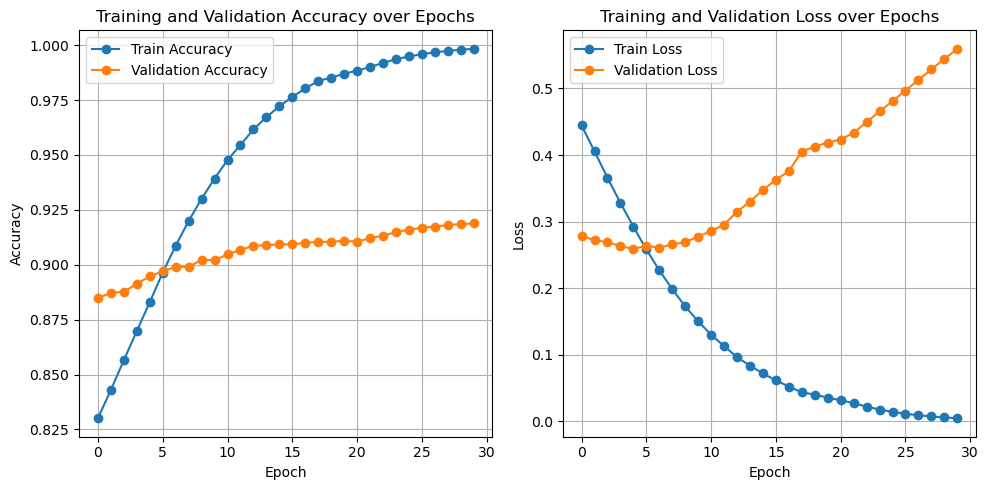

In [49]:
test_model_accuracy(model)

### One LSTM Three Dense and One Output Layer for Classification

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                32256     
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 16)                272       
                                                                 
 dense_22 (Dense)            (None, 3)                 51        
                                                                 
Total params: 33,891
Trainable params: 33,891
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 8s 16ms/step - loss: 0.4369 - accuracy: 0.8239 - val_loss: 0.2953 - val_accuracy: 0.8738
Epoch 2/30
350/350 [==============================] - 4s 11ms/step - loss: 0.2465 - accuracy: 0.8944 - val_loss: 0.2567 - val_accuracy: 0.8928
Epoch 3/30
350/350 [==============================] - 4s 10ms/step - loss: 0.2016 - accuracy: 0.9148 - val_loss: 0.2549 - val_accuracy: 0.8964
Epoch 4/30
350/350 [==============================] - 4s 10ms/step - loss: 0.1731 - accuracy: 0.9266 - val_loss: 0.2348 - val_accuracy: 0.9064
Epoch 5/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1426 - accuracy: 0.9416 - val_loss: 0.2344 - val_accuracy: 0.9110
Epoch 6/30
350/350 [==============================] - 4s 12ms/step - loss: 0.1197 - accuracy: 0.9498 - val_loss: 0.2464 - val_accuracy: 0.9107
Epoch 7/30
350/350 [==============================] - 4s 11ms/step - loss: 0.1024 - accuracy: 0.9585 - val_loss: 0.2813 - val_accuracy: 0.9081

110/110 [==============================] - 1s 5ms/step - loss: 0.5649 - accuracy: 0.9162
Test Accuracy: 91.6214%


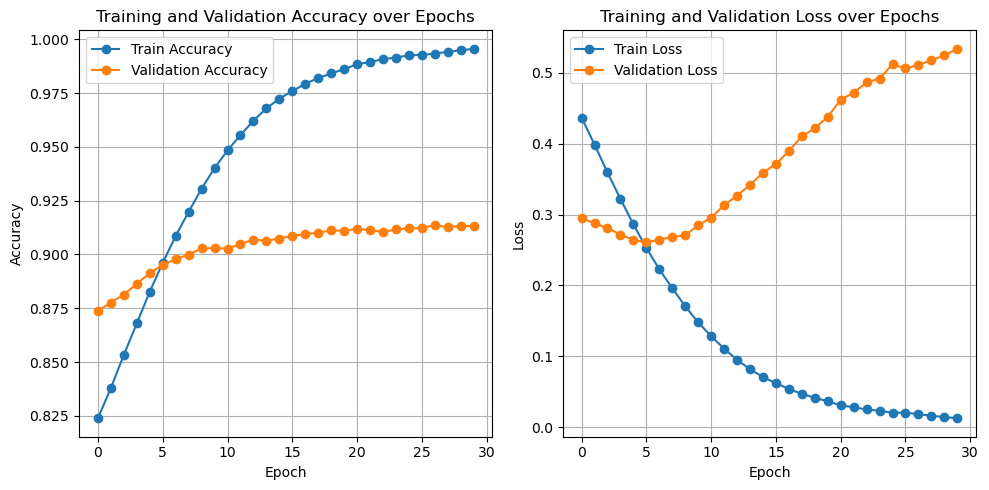

In [52]:
test_model_accuracy(model)

### Two LSTMs One Output Layer for Classification

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_25 (Dense)            (None, 3)                 99        
                                                                 
Total params: 44,771
Trainable params: 44,771
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 14s 25ms/step - loss: 0.3874 - accuracy: 0.8462 - val_loss: 0.2926 - val_accuracy: 0.8856
Epoch 2/30
350/350 [==============================] - 6s 16ms/step - loss: 0.2337 - accuracy: 0.9038 - val_loss: 0.2325 - val_accuracy: 0.9039
Epoch 3/30
350/350 [==============================] - 6s 18ms/step - loss: 0.1906 - accuracy: 0.9236 - val_loss: 0.2351 - val_accuracy: 0.9039
Epoch 4/30
350/350 [==============================] - 8s 21ms/step - loss: 0.1621 - accuracy: 0.9341 - val_loss: 0.2059 - val_accuracy: 0.9192
Epoch 5/30
350/350 [==============================] - 7s 19ms/step - loss: 0.1357 - accuracy: 0.9454 - val_loss: 0.2163 - val_accuracy: 0.9149
Epoch 6/30
350/350 [==============================] - 8s 22ms/step - loss: 0.1130 - accuracy: 0.9559 - val_loss: 0.2136 - val_accuracy: 0.9253
Epoch 7/30
350/350 [==============================] - 7s 20ms/step - loss: 0.0936 - accuracy: 0.9633 - val_loss: 0.2196 - val_accuracy: 0.923

110/110 [==============================] - 1s 6ms/step - loss: 0.4594 - accuracy: 0.9148
Test Accuracy: 91.4784%


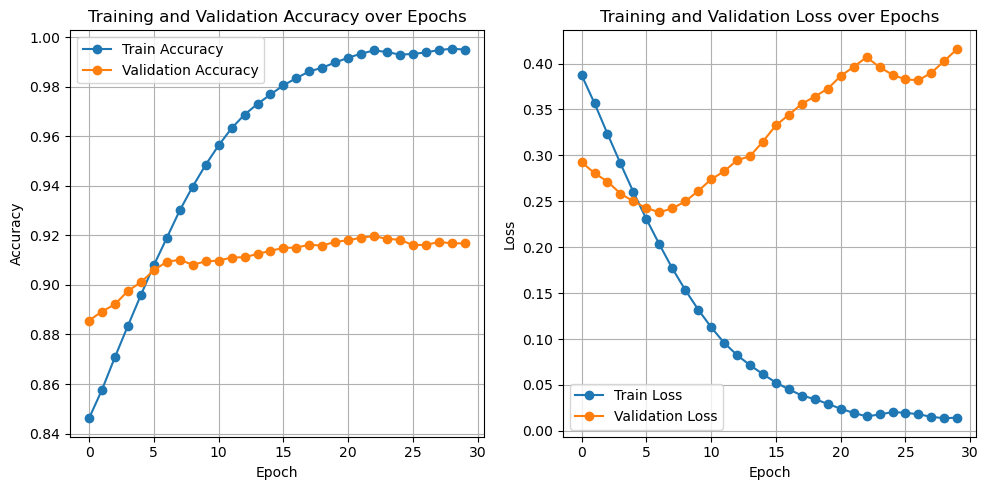

In [33]:
test_model_accuracy(model)

### Two LSTMs One Dense Layer and One Output Layer for Classification

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dense_24 (Dense)            (None, 3)                 51        
                                                                 
Total params: 45,251
Trainable params: 45,251
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 14s 24ms/step - loss: 0.3936 - accuracy: 0.8469 - val_loss: 0.2748 - val_accuracy: 0.8921
Epoch 2/30
350/350 [==============================] - 6s 16ms/step - loss: 0.2389 - accuracy: 0.8966 - val_loss: 0.2450 - val_accuracy: 0.8989
Epoch 3/30
350/350 [==============================] - 6s 18ms/step - loss: 0.1996 - accuracy: 0.9149 - val_loss: 0.2481 - val_accuracy: 0.9017
Epoch 4/30
350/350 [==============================] - 8s 22ms/step - loss: 0.1721 - accuracy: 0.9267 - val_loss: 0.2239 - val_accuracy: 0.9110
Epoch 5/30
350/350 [==============================] - 7s 20ms/step - loss: 0.1464 - accuracy: 0.9366 - val_loss: 0.2315 - val_accuracy: 0.9124
Epoch 6/30
350/350 [==============================] - 8s 22ms/step - loss: 0.1255 - accuracy: 0.9504 - val_loss: 0.2252 - val_accuracy: 0.9199
Epoch 7/30
350/350 [==============================] - 7s 19ms/step - loss: 0.1056 - accuracy: 0.9571 - val_loss: 0.2549 - val_accuracy: 0.913

110/110 [==============================] - 1s 6ms/step - loss: 0.4203 - accuracy: 0.9222
Test Accuracy: 92.2219%


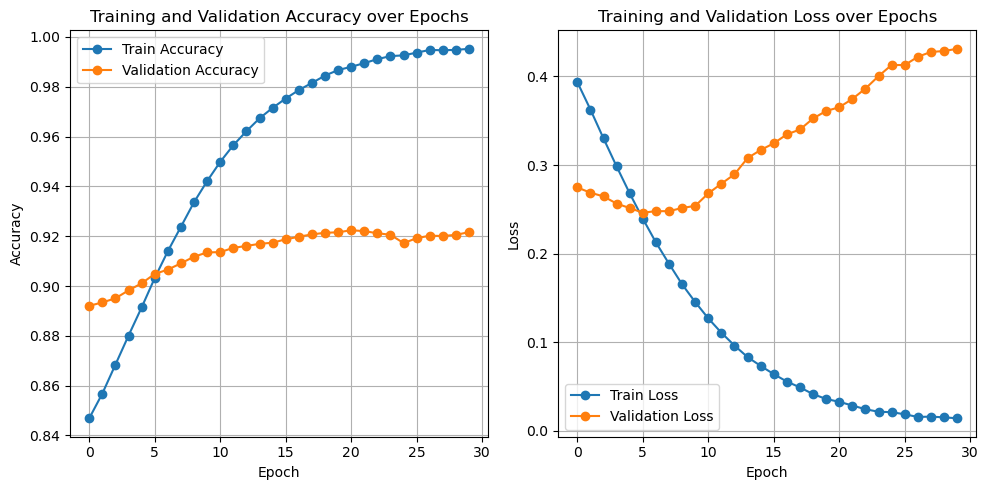

In [30]:
test_model_accuracy(model)

### Two LSTMs Two Dense Layer and One Output Layer for Classification

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 11, 64)            32256     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 3)                 51        
                                                                 
Total params: 45,523
Trainable params: 45,523
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 14s 25ms/step - loss: 0.4368 - accuracy: 0.8287 - val_loss: 0.2678 - val_accuracy: 0.8863
Epoch 2/30
350/350 [==============================] - 6s 16ms/step - loss: 0.2459 - accuracy: 0.8968 - val_loss: 0.2945 - val_accuracy: 0.8842
Epoch 3/30
350/350 [==============================] - 6s 19ms/step - loss: 0.2022 - accuracy: 0.9147 - val_loss: 0.2418 - val_accuracy: 0.9035
Epoch 4/30
350/350 [==============================] - 7s 20ms/step - loss: 0.1748 - accuracy: 0.9257 - val_loss: 0.2239 - val_accuracy: 0.9064
Epoch 5/30
350/350 [==============================] - 7s 19ms/step - loss: 0.1498 - accuracy: 0.9399 - val_loss: 0.2343 - val_accuracy: 0.9103
Epoch 6/30
350/350 [==============================] - 8s 22ms/step - loss: 0.1271 - accuracy: 0.9515 - val_loss: 0.2327 - val_accuracy: 0.9132
Epoch 7/30
350/350 [==============================] - 7s 20ms/step - loss: 0.1024 - accuracy: 0.9596 - val_loss: 0.2432 - val_accuracy: 0.914

110/110 [==============================] - 1s 8ms/step - loss: 0.4897 - accuracy: 0.9196
Test Accuracy: 91.9645%


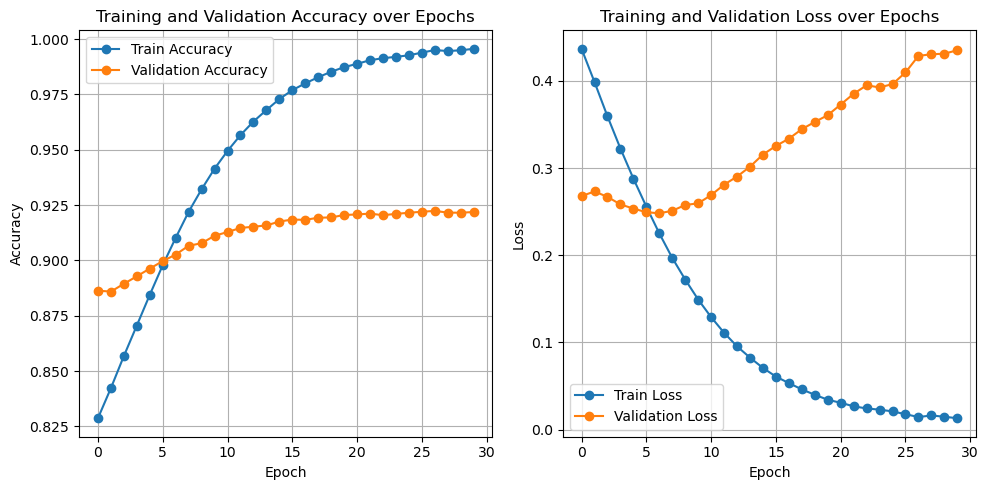

In [17]:
test_model_accuracy(model)

### Two LSTMs Three Dense Layer and One Output Layer for Classification

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 16)                272       
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dense_29 (Dense)            (None, 3)                 51        
                                                                 
Total params: 45,795
Trainable params: 45,795
Non-trai

In [36]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 15s 24ms/step - loss: 0.5226 - accuracy: 0.8058 - val_loss: 0.2776 - val_accuracy: 0.8831
Epoch 2/30
350/350 [==============================] - 6s 17ms/step - loss: 0.2526 - accuracy: 0.8936 - val_loss: 0.2486 - val_accuracy: 0.8989
Epoch 3/30
350/350 [==============================] - 7s 21ms/step - loss: 0.2045 - accuracy: 0.9138 - val_loss: 0.2267 - val_accuracy: 0.9092
Epoch 4/30
350/350 [==============================] - 7s 20ms/step - loss: 0.1725 - accuracy: 0.9297 - val_loss: 0.2393 - val_accuracy: 0.9121
Epoch 5/30
350/350 [==============================] - 7s 21ms/step - loss: 0.1454 - accuracy: 0.9401 - val_loss: 0.2228 - val_accuracy: 0.9214
Epoch 6/30
350/350 [==============================] - 7s 21ms/step - loss: 0.1200 - accuracy: 0.9543 - val_loss: 0.2497 - val_accuracy: 0.9067
Epoch 7/30
350/350 [==============================] - 7s 21ms/step - loss: 0.0994 - accuracy: 0.9586 - val_loss: 0.2404 - val_accuracy: 0.922

110/110 [==============================] - 1s 7ms/step - loss: 0.5175 - accuracy: 0.9162
Test Accuracy: 91.6214%


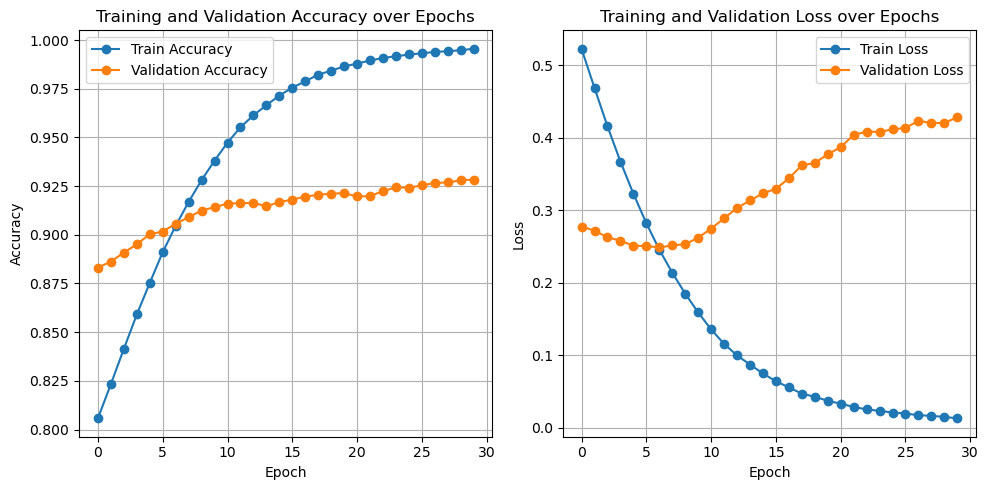

In [37]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 16)                272       
                                                                 
 dense_22 (Dense)            (None, 3)                

In [26]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 15s 25ms/step - loss: 0.4492 - accuracy: 0.8291 - val_loss: 0.2695 - val_accuracy: 0.8917
Epoch 2/30
350/350 [==============================] - 6s 17ms/step - loss: 0.2354 - accuracy: 0.9017 - val_loss: 0.2467 - val_accuracy: 0.8939
Epoch 3/30
350/350 [==============================] - 7s 19ms/step - loss: 0.1922 - accuracy: 0.9247 - val_loss: 0.2261 - val_accuracy: 0.9081
Epoch 4/30
350/350 [==============================] - 7s 20ms/step - loss: 0.1631 - accuracy: 0.9367 - val_loss: 0.2724 - val_accuracy: 0.9028
Epoch 5/30
350/350 [==============================] - 7s 21ms/step - loss: 0.1429 - accuracy: 0.9427 - val_loss: 0.2126 - val_accuracy: 0.9210
Epoch 6/30
350/350 [==============================] - 8s 22ms/step - loss: 0.1147 - accuracy: 0.9555 - val_loss: 0.2337 - val_accuracy: 0.9132
Epoch 7/30
350/350 [==============================] - 7s 20ms/step - loss: 0.0924 - accuracy: 0.9643 - val_loss: 0.2396 - val_accuracy: 0.923

110/110 [==============================] - 1s 7ms/step - loss: 0.5805 - accuracy: 0.9239
Test Accuracy: 92.3935%


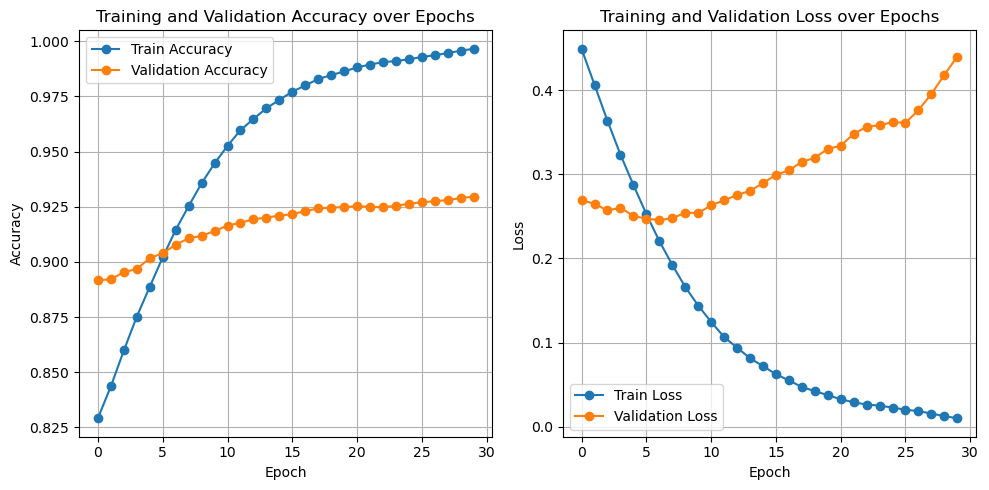

In [27]:
test_model_accuracy(model)

### Two LSTMs Five Dense Layer and One Output Layer for Classification

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 16)                272       
                                                                 
 dense_32 (Dense)            (None, 16)                272       
                                                                 
 dense_33 (Dense)            (None, 16)                272       
                                                                 
 dense_34 (Dense)            (None, 16)               

In [39]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 15s 24ms/step - loss: 0.5123 - accuracy: 0.7880 - val_loss: 0.2720 - val_accuracy: 0.8953
Epoch 2/30
350/350 [==============================] - 6s 18ms/step - loss: 0.2420 - accuracy: 0.8992 - val_loss: 0.2362 - val_accuracy: 0.9046
Epoch 3/30
350/350 [==============================] - 6s 18ms/step - loss: 0.2015 - accuracy: 0.9157 - val_loss: 0.2290 - val_accuracy: 0.9060
Epoch 4/30
350/350 [==============================] - 8s 22ms/step - loss: 0.1725 - accuracy: 0.9315 - val_loss: 0.2242 - val_accuracy: 0.9067
Epoch 5/30
350/350 [==============================] - 7s 20ms/step - loss: 0.1453 - accuracy: 0.9410 - val_loss: 0.2675 - val_accuracy: 0.8810
Epoch 6/30
350/350 [==============================] - 8s 23ms/step - loss: 0.1237 - accuracy: 0.9502 - val_loss: 0.2319 - val_accuracy: 0.9157
Epoch 7/30
350/350 [==============================] - 7s 20ms/step - loss: 0.0995 - accuracy: 0.9608 - val_loss: 0.2518 - val_accuracy: 0.916

110/110 [==============================] - 1s 11ms/step - loss: 0.3945 - accuracy: 0.9182
Test Accuracy: 91.8216%


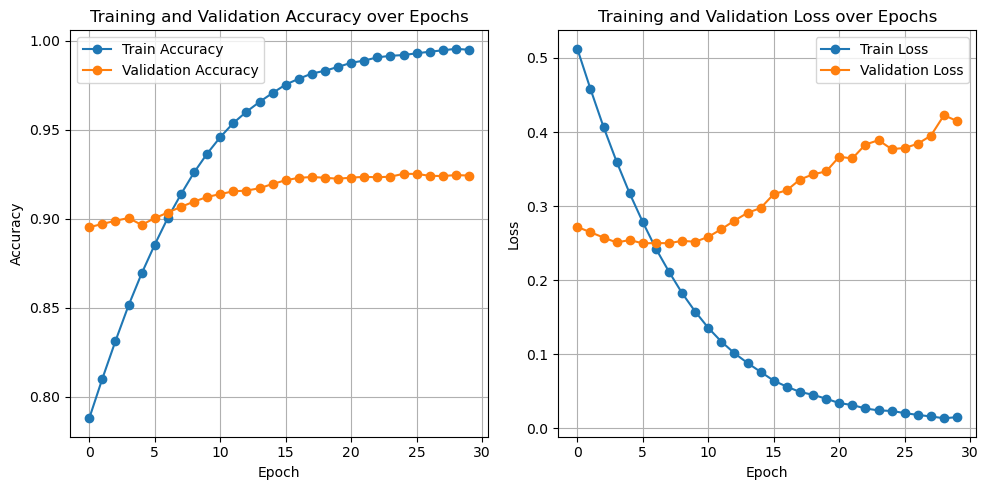

In [40]:
test_model_accuracy(model)

### Three LSTMs and One Output Layer for Classification

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh',return_sequences=True),
    LSTM(16, activation='tanh'),
    
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_21 (LSTM)              (None, 11, 32)            12416     
                                                                 
 lstm_22 (LSTM)              (None, 16)                3136      
                                                                 
 dense_36 (Dense)            (None, 3)                 51        
                                                                 
Total params: 47,859
Trainable params: 47,859
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2)

Epoch 1/30
350/350 [==============================] - 19s 30ms/step - loss: 0.4053 - accuracy: 0.8424 - val_loss: 0.2878 - val_accuracy: 0.8746
Epoch 2/30
350/350 [==============================] - 8s 24ms/step - loss: 0.2404 - accuracy: 0.8976 - val_loss: 0.2481 - val_accuracy: 0.8971
Epoch 3/30
350/350 [==============================] - 8s 24ms/step - loss: 0.2012 - accuracy: 0.9149 - val_loss: 0.2334 - val_accuracy: 0.9067
Epoch 4/30
350/350 [==============================] - 10s 28ms/step - loss: 0.1672 - accuracy: 0.9340 - val_loss: 0.2251 - val_accuracy: 0.9160
Epoch 5/30
350/350 [==============================] - 9s 26ms/step - loss: 0.1391 - accuracy: 0.9460 - val_loss: 0.2251 - val_accuracy: 0.9210
Epoch 6/30
350/350 [==============================] - 10s 29ms/step - loss: 0.1158 - accuracy: 0.9558 - val_loss: 0.2389 - val_accuracy: 0.9132
Epoch 7/30
350/350 [==============================] - 9s 26ms/step - loss: 0.0952 - accuracy: 0.9624 - val_loss: 0.2352 - val_accuracy: 0.9

110/110 [==============================] - 1s 9ms/step - loss: 0.4070 - accuracy: 0.9211
Test Accuracy: 92.1075%


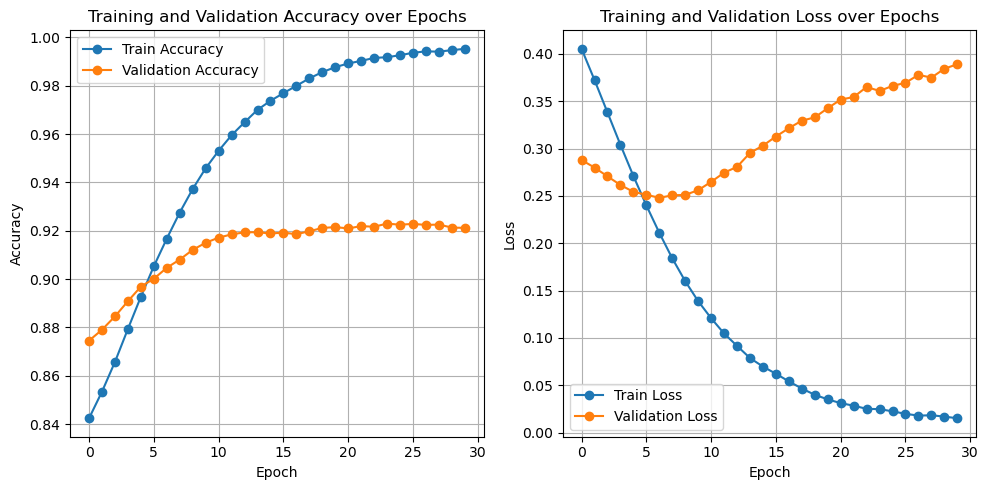

In [45]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Testing with Batch Size 64 

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_24 (LSTM)              (None, 32)                12416     
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 (Dense)            (None, 16)                272       
                                                                 
 dense_39 (Dense)            (None, 16)                272       
                                                                 
 dense_40 (Dense)            (None, 16)                272       
                                                                 
 dense_41 (Dense)            (None, 3)               

In [47]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 12s 32ms/step - loss: 0.5283 - accuracy: 0.7884 - val_loss: 0.2810 - val_accuracy: 0.8856
Epoch 2/30
175/175 [==============================] - 4s 21ms/step - loss: 0.2554 - accuracy: 0.8930 - val_loss: 0.2568 - val_accuracy: 0.8967
Epoch 3/30
175/175 [==============================] - 4s 25ms/step - loss: 0.2112 - accuracy: 0.9094 - val_loss: 0.2423 - val_accuracy: 0.9053
Epoch 4/30
175/175 [==============================] - 4s 22ms/step - loss: 0.1858 - accuracy: 0.9224 - val_loss: 0.2551 - val_accuracy: 0.9017
Epoch 5/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1663 - accuracy: 0.9321 - val_loss: 0.2266 - val_accuracy: 0.9128
Epoch 6/30
175/175 [==============================] - 4s 24ms/step - loss: 0.1389 - accuracy: 0.9443 - val_loss: 0.2310 - val_accuracy: 0.9135
Epoch 7/30
175/175 [==============================] - 5s 27ms/step - loss: 0.1307 - accuracy: 0.9502 - val_loss: 0.2270 - val_accuracy: 0.913

110/110 [==============================] - 1s 8ms/step - loss: 0.4096 - accuracy: 0.9236
Test Accuracy: 92.3649%


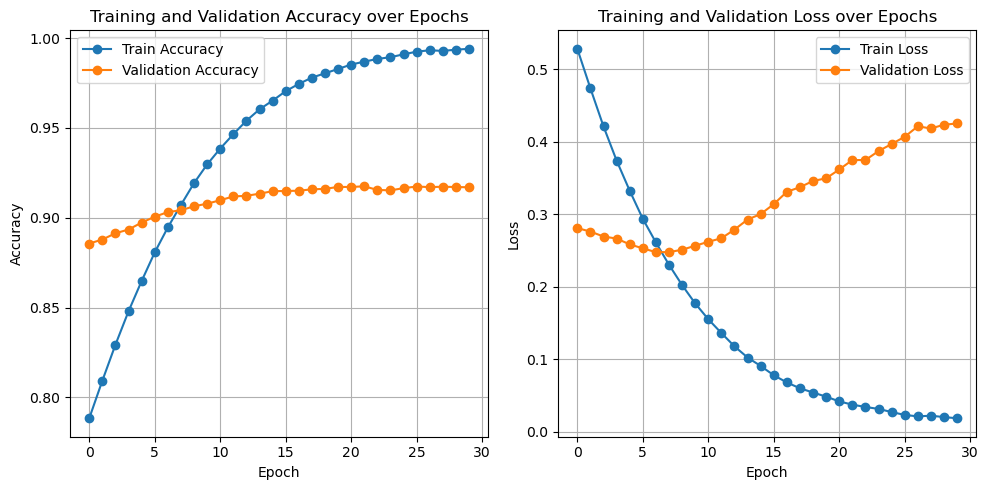

In [48]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Testing with Batch Size 16 

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 11, 64)            32256     
                                                                 
 lstm_26 (LSTM)              (None, 32)                12416     
                                                                 
 dense_42 (Dense)            (None, 16)                528       
                                                                 
 dense_43 (Dense)            (None, 16)                272       
                                                                 
 dense_44 (Dense)            (None, 16)                272       
                                                                 
 dense_45 (Dense)            (None, 16)                272       
                                                                 
 dense_46 (Dense)            (None, 3)               

In [51]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=16)

Epoch 1/30
700/700 [==============================] - 20s 22ms/step - loss: 0.4032 - accuracy: 0.8450 - val_loss: 0.3043 - val_accuracy: 0.8803
Epoch 2/30
700/700 [==============================] - 12s 18ms/step - loss: 0.2405 - accuracy: 0.8991 - val_loss: 0.2512 - val_accuracy: 0.9021
Epoch 3/30
700/700 [==============================] - 13s 19ms/step - loss: 0.1984 - accuracy: 0.9161 - val_loss: 0.2332 - val_accuracy: 0.9074
Epoch 4/30
700/700 [==============================] - 13s 19ms/step - loss: 0.1706 - accuracy: 0.9258 - val_loss: 0.2206 - val_accuracy: 0.9124
Epoch 5/30
700/700 [==============================] - 14s 20ms/step - loss: 0.1413 - accuracy: 0.9411 - val_loss: 0.2819 - val_accuracy: 0.8956
Epoch 6/30
700/700 [==============================] - 13s 19ms/step - loss: 0.1227 - accuracy: 0.9483 - val_loss: 0.2378 - val_accuracy: 0.9103
Epoch 7/30
700/700 [==============================] - 13s 19ms/step - loss: 0.0993 - accuracy: 0.9595 - val_loss: 0.2572 - val_accuracy:

110/110 [==============================] - 1s 9ms/step - loss: 0.4622 - accuracy: 0.9125
Test Accuracy: 91.2496%


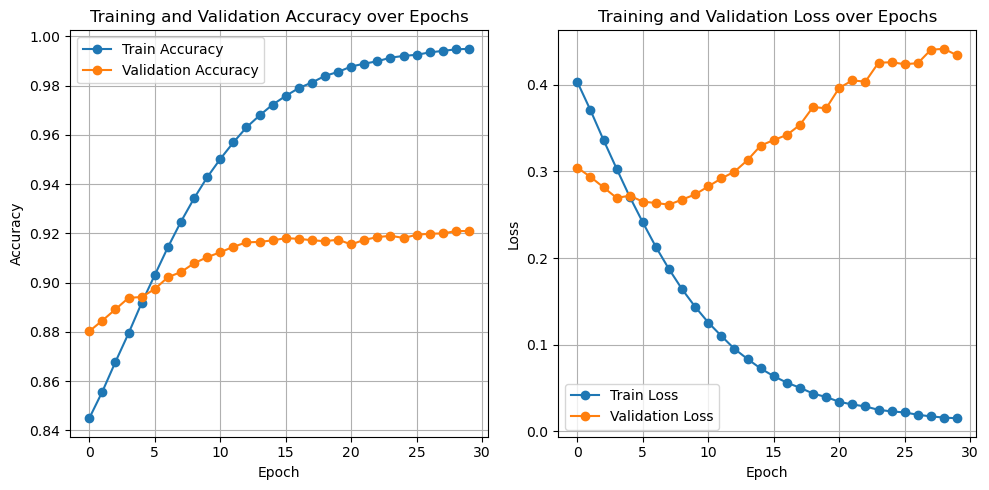

In [52]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Changing Specifics of LSTMs

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(128, activation='tanh',return_sequences=True),
    LSTM(64, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 11, 128)           97280     
                                                                 
 lstm_28 (LSTM)              (None, 64)                49408     
                                                                 
 dense_47 (Dense)            (None, 16)                1040      
                                                                 
 dense_48 (Dense)            (None, 16)                272       
                                                                 
 dense_49 (Dense)            (None, 16)                272       
                                                                 
 dense_50 (Dense)            (None, 16)                272       
                                                                 
 dense_51 (Dense)            (None, 3)               

In [55]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 7s 42ms/step - loss: 0.3015 - accuracy: 0.8777 - val_loss: 0.2659 - val_accuracy: 0.8914
Epoch 2/30
175/175 [==============================] - 6s 32ms/step - loss: 0.2330 - accuracy: 0.9023 - val_loss: 0.2523 - val_accuracy: 0.8939
Epoch 3/30
175/175 [==============================] - 5s 28ms/step - loss: 0.1916 - accuracy: 0.9214 - val_loss: 0.2267 - val_accuracy: 0.9128
Epoch 4/30
175/175 [==============================] - 6s 35ms/step - loss: 0.1664 - accuracy: 0.9337 - val_loss: 0.2520 - val_accuracy: 0.8903
Epoch 5/30
175/175 [==============================] - 6s 35ms/step - loss: 0.1393 - accuracy: 0.9469 - val_loss: 0.2157 - val_accuracy: 0.9189
Epoch 6/30
175/175 [==============================] - 7s 38ms/step - loss: 0.1170 - accuracy: 0.9538 - val_loss: 0.2174 - val_accuracy: 0.9228
Epoch 7/30
175/175 [==============================] - 7s 43ms/step - loss: 0.0978 - accuracy: 0.9623 - val_loss: 0.2177 - val_accuracy: 0.9232

110/110 [==============================] - 1s 9ms/step - loss: 0.4190 - accuracy: 0.9259
Test Accuracy: 92.5937%


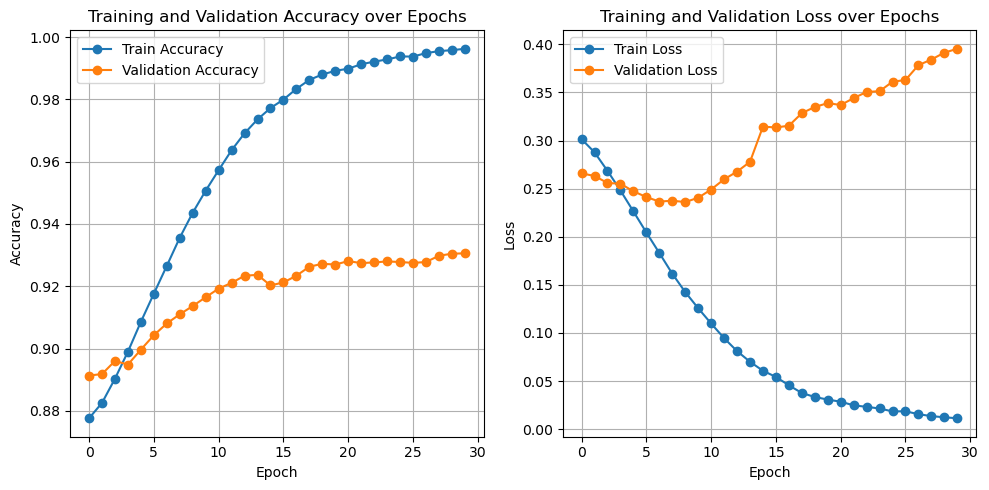

In [56]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Changing Specifics of LSTMs more (selected for next step)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_30 (LSTM)              (None, 128)               197120    
                                                                 
 dense_52 (Dense)            (None, 16)                2064      
                                                                 
 dense_53 (Dense)            (None, 16)                272       
                                                                 
 dense_54 (Dense)            (None, 16)                272       
                                                                 
 dense_55 (Dense)            (None, 16)                272       
                                                                 
 dense_56 (Dense)            (None, 3)               

In [58]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 19s 73ms/step - loss: 0.4446 - accuracy: 0.8012 - val_loss: 0.2675 - val_accuracy: 0.8842
Epoch 2/30
175/175 [==============================] - 13s 74ms/step - loss: 0.2386 - accuracy: 0.8996 - val_loss: 0.2598 - val_accuracy: 0.8867
Epoch 3/30
175/175 [==============================] - 14s 78ms/step - loss: 0.1943 - accuracy: 0.9220 - val_loss: 0.2103 - val_accuracy: 0.9221
Epoch 4/30
175/175 [==============================] - 15s 85ms/step - loss: 0.1564 - accuracy: 0.9384 - val_loss: 0.2285 - val_accuracy: 0.9139
Epoch 5/30
175/175 [==============================] - 14s 78ms/step - loss: 0.1252 - accuracy: 0.9516 - val_loss: 0.1907 - val_accuracy: 0.9274
Epoch 6/30
175/175 [==============================] - 14s 81ms/step - loss: 0.0994 - accuracy: 0.9643 - val_loss: 0.2210 - val_accuracy: 0.9278
Epoch 7/30
175/175 [==============================] - 14s 83ms/step - loss: 0.0846 - accuracy: 0.9681 - val_loss: 0.2529 - val_accuracy:

110/110 [==============================] - 2s 17ms/step - loss: 0.4223 - accuracy: 0.9405
Test Accuracy: 94.0520%


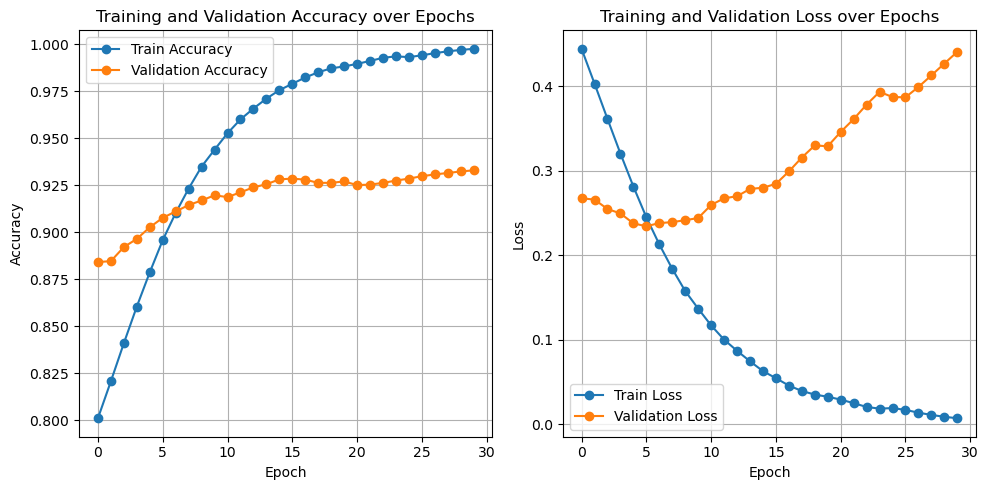

In [59]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Increasing the Kernel Size

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(512, activation='tanh',return_sequences=True),
    LSTM(256, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 11, 512)           1175552   
                                                                 
 lstm_32 (LSTM)              (None, 256)               787456    
                                                                 
 dense_57 (Dense)            (None, 16)                4112      
                                                                 
 dense_58 (Dense)            (None, 16)                272       
                                                                 
 dense_59 (Dense)            (None, 16)                272       
                                                                 
 dense_60 (Dense)            (None, 16)                272       
                                                                 
 dense_61 (Dense)            (None, 3)               

In [61]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 43s 212ms/step - loss: 0.4373 - accuracy: 0.8085 - val_loss: 0.2760 - val_accuracy: 0.8914
Epoch 2/30
175/175 [==============================] - 39s 223ms/step - loss: 0.2482 - accuracy: 0.8972 - val_loss: 0.2369 - val_accuracy: 0.9056
Epoch 3/30
175/175 [==============================] - 38s 219ms/step - loss: 0.1925 - accuracy: 0.9213 - val_loss: 0.2184 - val_accuracy: 0.9174
Epoch 4/30
175/175 [==============================] - 39s 225ms/step - loss: 0.1586 - accuracy: 0.9368 - val_loss: 0.1943 - val_accuracy: 0.9271
Epoch 5/30
175/175 [==============================] - 40s 227ms/step - loss: 0.1349 - accuracy: 0.9495 - val_loss: 0.1871 - val_accuracy: 0.9328
Epoch 6/30
175/175 [==============================] - 42s 238ms/step - loss: 0.1085 - accuracy: 0.9576 - val_loss: 0.1914 - val_accuracy: 0.9332
Epoch 7/30
175/175 [==============================] - 40s 227ms/step - loss: 0.0973 - accuracy: 0.9643 - val_loss: 0.1927 - val_ac

110/110 [==============================] - 5s 47ms/step - loss: 0.3637 - accuracy: 0.9391
Test Accuracy: 93.9091%


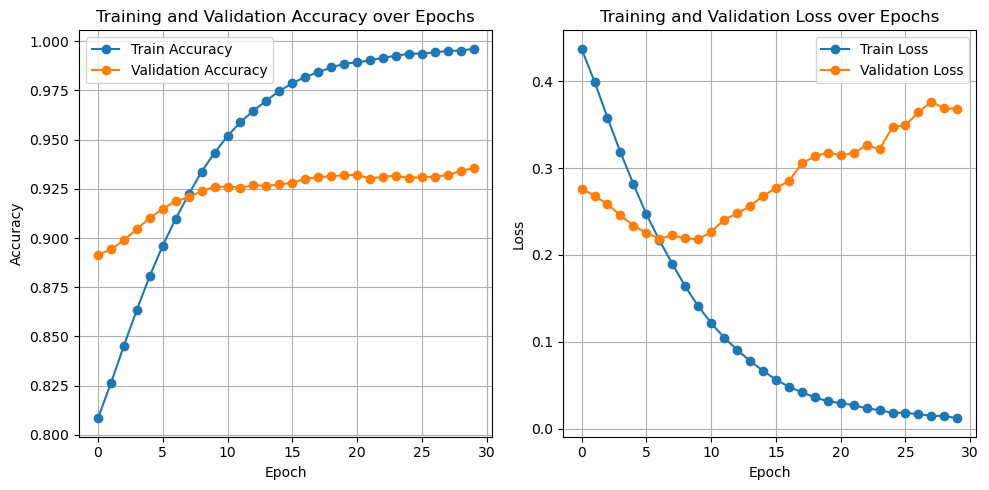

In [62]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Increasing the Kernel Size (Using 256-256)

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(256, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_34 (LSTM)              (None, 256)               525312    
                                                                 
 dense_62 (Dense)            (None, 16)                4112      
                                                                 
 dense_63 (Dense)            (None, 16)                272       
                                                                 
 dense_64 (Dense)            (None, 16)                272       
                                                                 
 dense_65 (Dense)            (None, 16)                272       
                                                                 
 dense_66 (Dense)            (None, 3)               

In [64]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 41s 99ms/step - loss: 0.4401 - accuracy: 0.8164 - val_loss: 0.2813 - val_accuracy: 0.8867
Epoch 2/30
175/175 [==============================] - 19s 111ms/step - loss: 0.2505 - accuracy: 0.8956 - val_loss: 0.2336 - val_accuracy: 0.9035
Epoch 3/30
175/175 [==============================] - 22s 126ms/step - loss: 0.2006 - accuracy: 0.9144 - val_loss: 0.2331 - val_accuracy: 0.9046
Epoch 4/30
175/175 [==============================] - 21s 120ms/step - loss: 0.1708 - accuracy: 0.9309 - val_loss: 0.1968 - val_accuracy: 0.9292
Epoch 5/30
175/175 [==============================] - 20s 116ms/step - loss: 0.1360 - accuracy: 0.9478 - val_loss: 0.2026 - val_accuracy: 0.9249
Epoch 6/30
175/175 [==============================] - 21s 120ms/step - loss: 0.1132 - accuracy: 0.9579 - val_loss: 0.1895 - val_accuracy: 0.9350
Epoch 7/30
175/175 [==============================] - 20s 114ms/step - loss: 0.0935 - accuracy: 0.9648 - val_loss: 0.2066 - val_acc

110/110 [==============================] - 3s 24ms/step - loss: 0.3602 - accuracy: 0.9374
Test Accuracy: 93.7375%


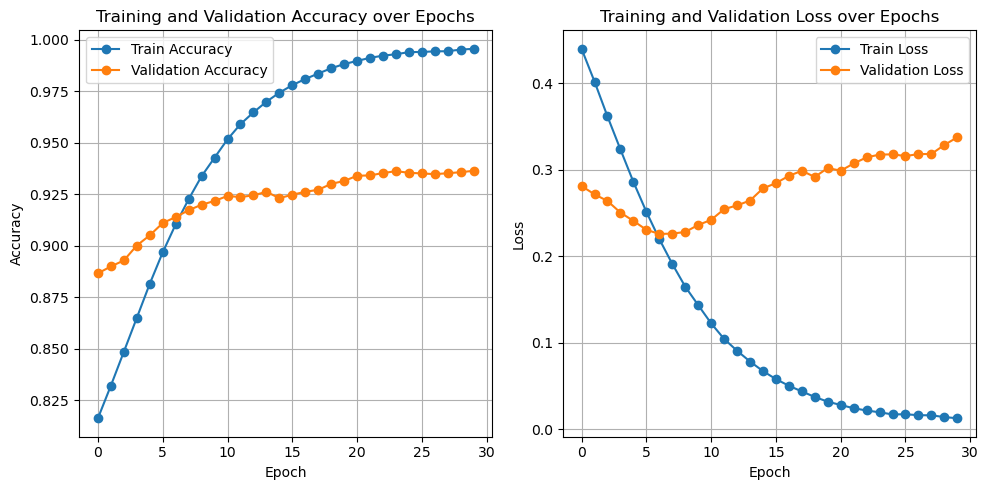

In [65]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Changing Specifics of Dense Layers (Making all 64)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_38 (LSTM)              (None, 128)               197120    
                                                                 
 dense_72 (Dense)            (None, 64)                8256      
                                                                 
 dense_73 (Dense)            (None, 64)                4160      
                                                                 
 dense_74 (Dense)            (None, 64)                4160      
                                                                 
 dense_75 (Dense)            (None, 64)                4160      
                                                                 
 dense_76 (Dense)            (None, 3)               

In [68]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 21s 76ms/step - loss: 0.3759 - accuracy: 0.8510 - val_loss: 0.2861 - val_accuracy: 0.8746
Epoch 2/30
175/175 [==============================] - 12s 66ms/step - loss: 0.2422 - accuracy: 0.8972 - val_loss: 0.2456 - val_accuracy: 0.8903
Epoch 3/30
175/175 [==============================] - 14s 78ms/step - loss: 0.1892 - accuracy: 0.9228 - val_loss: 0.2115 - val_accuracy: 0.9199
Epoch 4/30
175/175 [==============================] - 14s 79ms/step - loss: 0.1579 - accuracy: 0.9371 - val_loss: 0.1875 - val_accuracy: 0.9271
Epoch 5/30
175/175 [==============================] - 15s 83ms/step - loss: 0.1254 - accuracy: 0.9504 - val_loss: 0.1904 - val_accuracy: 0.9375
Epoch 6/30
175/175 [==============================] - 15s 86ms/step - loss: 0.1107 - accuracy: 0.9557 - val_loss: 0.1956 - val_accuracy: 0.9332
Epoch 7/30
175/175 [==============================] - 14s 80ms/step - loss: 0.0900 - accuracy: 0.9660 - val_loss: 0.2223 - val_accuracy:

110/110 [==============================] - 2s 14ms/step - loss: 0.3329 - accuracy: 0.9311
Test Accuracy: 93.1084%


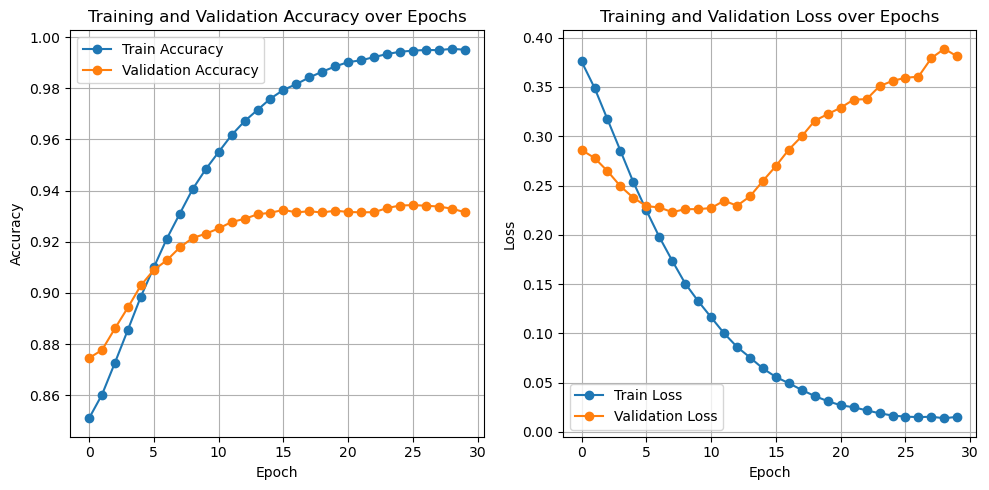

In [69]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Changing Specifics of Dense Layers (Making all 32)

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_40 (LSTM)              (None, 128)               197120    
                                                                 
 dense_77 (Dense)            (None, 32)                4128      
                                                                 
 dense_78 (Dense)            (None, 32)                1056      
                                                                 
 dense_79 (Dense)            (None, 32)                1056      
                                                                 
 dense_80 (Dense)            (None, 32)                1056      
                                                                 
 dense_81 (Dense)            (None, 3)               

In [71]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 20s 73ms/step - loss: 0.3774 - accuracy: 0.8524 - val_loss: 0.2787 - val_accuracy: 0.8867
Epoch 2/30
175/175 [==============================] - 13s 75ms/step - loss: 0.2333 - accuracy: 0.9022 - val_loss: 0.2350 - val_accuracy: 0.9064
Epoch 3/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1945 - accuracy: 0.9193 - val_loss: 0.2363 - val_accuracy: 0.8953
Epoch 4/30
175/175 [==============================] - 15s 84ms/step - loss: 0.1525 - accuracy: 0.9374 - val_loss: 0.2003 - val_accuracy: 0.9299
Epoch 5/30
175/175 [==============================] - 14s 82ms/step - loss: 0.1267 - accuracy: 0.9491 - val_loss: 0.1935 - val_accuracy: 0.9339
Epoch 6/30
175/175 [==============================] - 14s 78ms/step - loss: 0.1039 - accuracy: 0.9609 - val_loss: 0.2188 - val_accuracy: 0.9132
Epoch 7/30
175/175 [==============================] - 14s 78ms/step - loss: 0.0829 - accuracy: 0.9679 - val_loss: 0.2146 - val_accuracy:

110/110 [==============================] - 2s 16ms/step - loss: 0.4415 - accuracy: 0.9297
Test Accuracy: 92.9654%


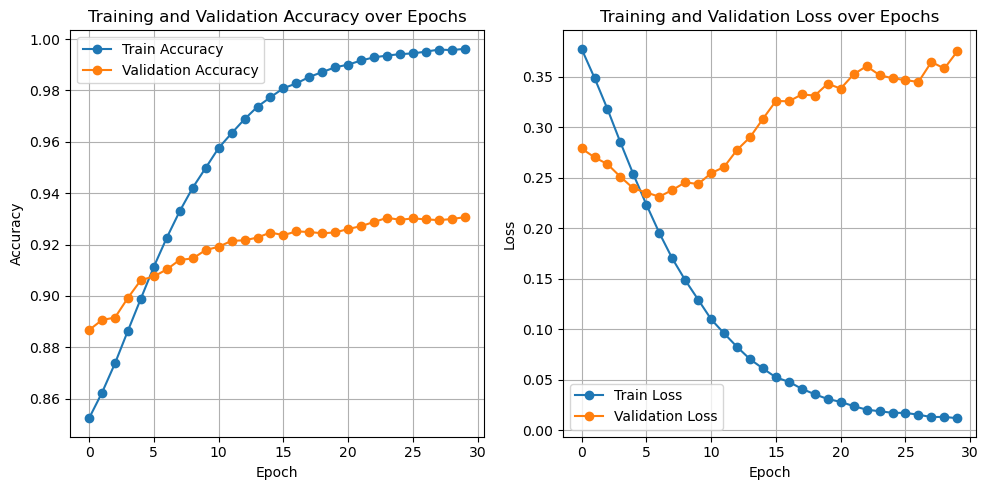

In [72]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Changing Specifics of Dense Layers (Decrasing Order)

In [75]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_46 (LSTM)              (None, 128)               197120    
                                                                 
 dense_92 (Dense)            (None, 32)                4128      
                                                                 
 dense_93 (Dense)            (None, 32)                1056      
                                                                 
 dense_94 (Dense)            (None, 16)                528       
                                                                 
 dense_95 (Dense)            (None, 16)                272       
                                                                 
 dense_96 (Dense)            (None, 3)               

In [76]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 20s 73ms/step - loss: 0.3947 - accuracy: 0.8412 - val_loss: 0.2709 - val_accuracy: 0.8899
Epoch 2/30
175/175 [==============================] - 12s 70ms/step - loss: 0.2327 - accuracy: 0.9009 - val_loss: 0.2545 - val_accuracy: 0.8953
Epoch 3/30
175/175 [==============================] - 15s 83ms/step - loss: 0.1956 - accuracy: 0.9205 - val_loss: 0.2436 - val_accuracy: 0.8924
Epoch 4/30
175/175 [==============================] - 14s 79ms/step - loss: 0.1617 - accuracy: 0.9333 - val_loss: 0.2108 - val_accuracy: 0.9203
Epoch 5/30
175/175 [==============================] - 14s 83ms/step - loss: 0.1304 - accuracy: 0.9461 - val_loss: 0.2019 - val_accuracy: 0.9257
Epoch 6/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1069 - accuracy: 0.9577 - val_loss: 0.2155 - val_accuracy: 0.9314
Epoch 7/30
175/175 [==============================] - 15s 85ms/step - loss: 0.0871 - accuracy: 0.9656 - val_loss: 0.2361 - val_accuracy:

110/110 [==============================] - 2s 21ms/step - loss: 0.3982 - accuracy: 0.9334
Test Accuracy: 93.3371%


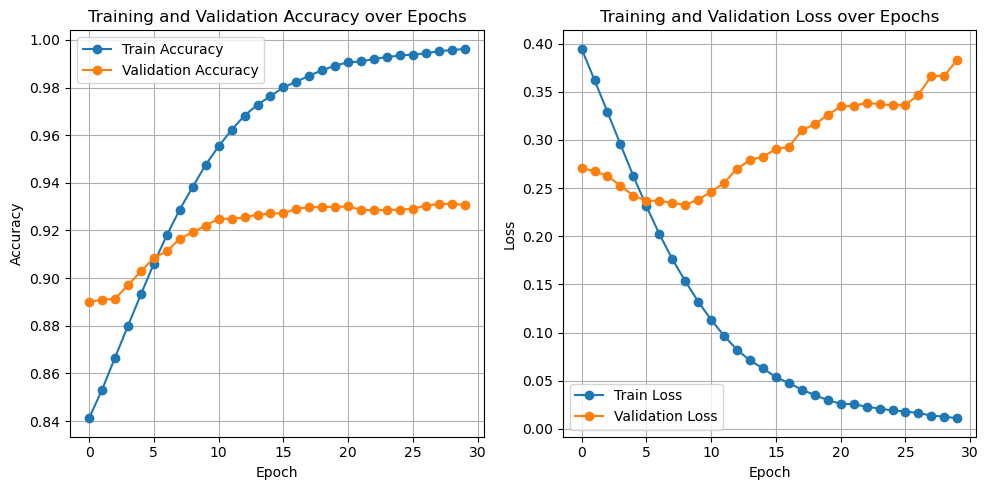

In [77]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Changing Specifics of Dense Layers (Making them 8)

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_50 (LSTM)              (None, 128)               197120    
                                                                 
 dense_102 (Dense)           (None, 8)                 1032      
                                                                 
 dense_103 (Dense)           (None, 8)                 72        
                                                                 
 dense_104 (Dense)           (None, 8)                 72        
                                                                 
 dense_105 (Dense)           (None, 8)                 72        
                                                                 
 dense_106 (Dense)           (None, 3)               

In [80]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 22s 82ms/step - loss: 0.4980 - accuracy: 0.8262 - val_loss: 0.2926 - val_accuracy: 0.8806
Epoch 2/30
175/175 [==============================] - 13s 76ms/step - loss: 0.2375 - accuracy: 0.9020 - val_loss: 0.2735 - val_accuracy: 0.8871
Epoch 3/30
175/175 [==============================] - 14s 78ms/step - loss: 0.1951 - accuracy: 0.9203 - val_loss: 0.2026 - val_accuracy: 0.9224
Epoch 4/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1540 - accuracy: 0.9390 - val_loss: 0.1902 - val_accuracy: 0.9260
Epoch 5/30
175/175 [==============================] - 15s 85ms/step - loss: 0.1260 - accuracy: 0.9509 - val_loss: 0.1844 - val_accuracy: 0.9339
Epoch 6/30
175/175 [==============================] - 14s 81ms/step - loss: 0.0974 - accuracy: 0.9631 - val_loss: 0.2018 - val_accuracy: 0.9260
Epoch 7/30
175/175 [==============================] - 14s 81ms/step - loss: 0.0805 - accuracy: 0.9707 - val_loss: 0.2142 - val_accuracy:

110/110 [==============================] - 2s 16ms/step - loss: 0.3285 - accuracy: 0.9399
Test Accuracy: 93.9948%


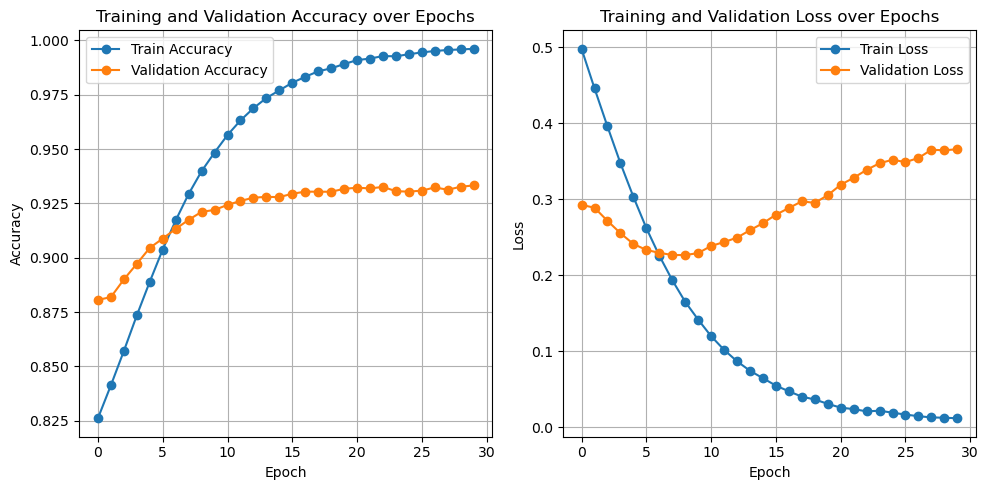

In [81]:
test_model_accuracy(model)

### Two LSTMs Four Dense Layer and One Output Layer for Classification (Selected for the Next Stage)
#### Changing Specifics of Dense Layers (Making Half of Them 16 and Other Half 8)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_52 (LSTM)              (None, 128)               197120    
                                                                 
 dense_107 (Dense)           (None, 16)                2064      
                                                                 
 dense_108 (Dense)           (None, 16)                272       
                                                                 
 dense_109 (Dense)           (None, 8)                 136       
                                                                 
 dense_110 (Dense)           (None, 8)                 72        
                                                                 
 dense_111 (Dense)           (None, 3)               

In [83]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 20s 67ms/step - loss: 0.4936 - accuracy: 0.7613 - val_loss: 0.2997 - val_accuracy: 0.8842
Epoch 2/30
175/175 [==============================] - 13s 72ms/step - loss: 0.2613 - accuracy: 0.8928 - val_loss: 0.2495 - val_accuracy: 0.8960
Epoch 3/30
175/175 [==============================] - 14s 80ms/step - loss: 0.2152 - accuracy: 0.9102 - val_loss: 0.2461 - val_accuracy: 0.8981
Epoch 4/30
175/175 [==============================] - 14s 82ms/step - loss: 0.1788 - accuracy: 0.9289 - val_loss: 0.2028 - val_accuracy: 0.9203
Epoch 5/30
175/175 [==============================] - 14s 83ms/step - loss: 0.1440 - accuracy: 0.9429 - val_loss: 0.2123 - val_accuracy: 0.9224
Epoch 6/30
175/175 [==============================] - 14s 79ms/step - loss: 0.1218 - accuracy: 0.9504 - val_loss: 0.1970 - val_accuracy: 0.9332
Epoch 7/30
175/175 [==============================] - 14s 79ms/step - loss: 0.1085 - accuracy: 0.9591 - val_loss: 0.1920 - val_accuracy:

110/110 [==============================] - 2s 20ms/step - loss: 0.3750 - accuracy: 0.9345
Test Accuracy: 93.4515%


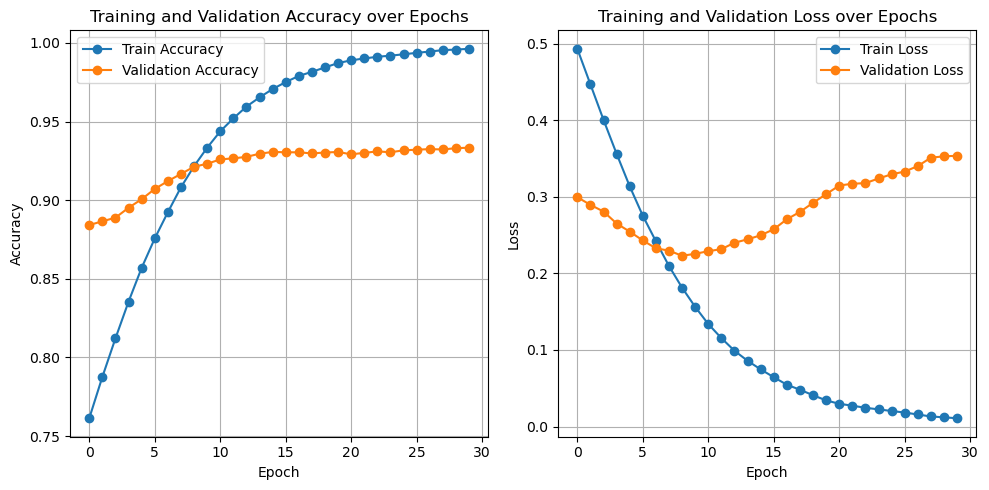

In [84]:
test_model_accuracy(model)

## Adding Flatten Layer

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_53 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_54 (LSTM)              (None, 128)               197120    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_112 (Dense)           (None, 16)                2064      
                                                                 
 dense_113 (Dense)           (None, 16)                272       
                                                                 
 dense_114 (Dense)           (None, 16)                272       
                                                                 
 dense_115 (Dense)           (None, 16)              

In [86]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 25s 86ms/step - loss: 0.4446 - accuracy: 0.8351 - val_loss: 0.2896 - val_accuracy: 0.8860
Epoch 2/30
175/175 [==============================] - 12s 70ms/step - loss: 0.2434 - accuracy: 0.8931 - val_loss: 0.2382 - val_accuracy: 0.9024
Epoch 3/30
175/175 [==============================] - 14s 78ms/step - loss: 0.1979 - accuracy: 0.9197 - val_loss: 0.2266 - val_accuracy: 0.9114
Epoch 4/30
175/175 [==============================] - 14s 77ms/step - loss: 0.1593 - accuracy: 0.9374 - val_loss: 0.2097 - val_accuracy: 0.9242
Epoch 5/30
175/175 [==============================] - 15s 86ms/step - loss: 0.1341 - accuracy: 0.9475 - val_loss: 0.2055 - val_accuracy: 0.9249
Epoch 6/30
175/175 [==============================] - 15s 83ms/step - loss: 0.1083 - accuracy: 0.9567 - val_loss: 0.2026 - val_accuracy: 0.9257
Epoch 7/30
175/175 [==============================] - 14s 82ms/step - loss: 0.0943 - accuracy: 0.9645 - val_loss: 0.2096 - val_accuracy:

110/110 [==============================] - 2s 15ms/step - loss: 0.4254 - accuracy: 0.9282
Test Accuracy: 92.8224%


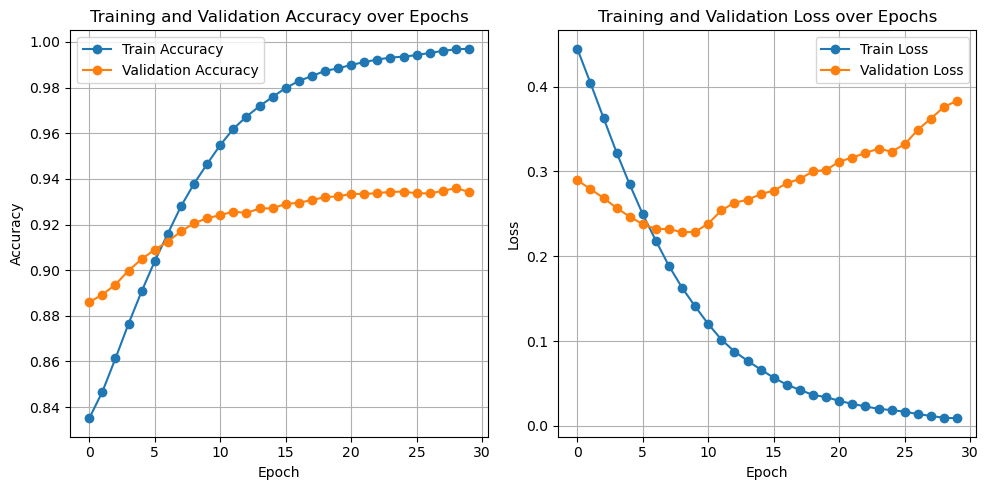

In [87]:
test_model_accuracy(model)

## Adding Batch Normalization
### Only 1 Batch Normalization Layer After First LSTM

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization (BatchN  (None, 11, 256)          1024      
 ormalization)                                                   
                                                                 
 lstm_56 (LSTM)              (None, 128)               197120    
                                                                 
 dense_117 (Dense)           (None, 16)                2064      
                                                                 
 dense_118 (Dense)           (None, 16)                272       
                                                                 
 dense_119 (Dense)           (None, 16)                272       
                                                     

In [89]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 44s 165ms/step - loss: 0.4295 - accuracy: 0.8460 - val_loss: 0.2790 - val_accuracy: 0.8888
Epoch 2/30
175/175 [==============================] - 11s 65ms/step - loss: 0.2462 - accuracy: 0.8990 - val_loss: 0.2558 - val_accuracy: 0.8960
Epoch 3/30
175/175 [==============================] - 15s 85ms/step - loss: 0.2122 - accuracy: 0.9091 - val_loss: 0.2368 - val_accuracy: 0.9056
Epoch 4/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1770 - accuracy: 0.9267 - val_loss: 0.2219 - val_accuracy: 0.9171
Epoch 5/30
175/175 [==============================] - 14s 82ms/step - loss: 0.1440 - accuracy: 0.9404 - val_loss: 0.1936 - val_accuracy: 0.9271
Epoch 6/30
175/175 [==============================] - 15s 84ms/step - loss: 0.1138 - accuracy: 0.9546 - val_loss: 0.2020 - val_accuracy: 0.9296
Epoch 7/30
175/175 [==============================] - 16s 90ms/step - loss: 0.0935 - accuracy: 0.9645 - val_loss: 0.2184 - val_accuracy

110/110 [==============================] - 2s 16ms/step - loss: 0.3128 - accuracy: 0.9348
Test Accuracy: 93.4801%


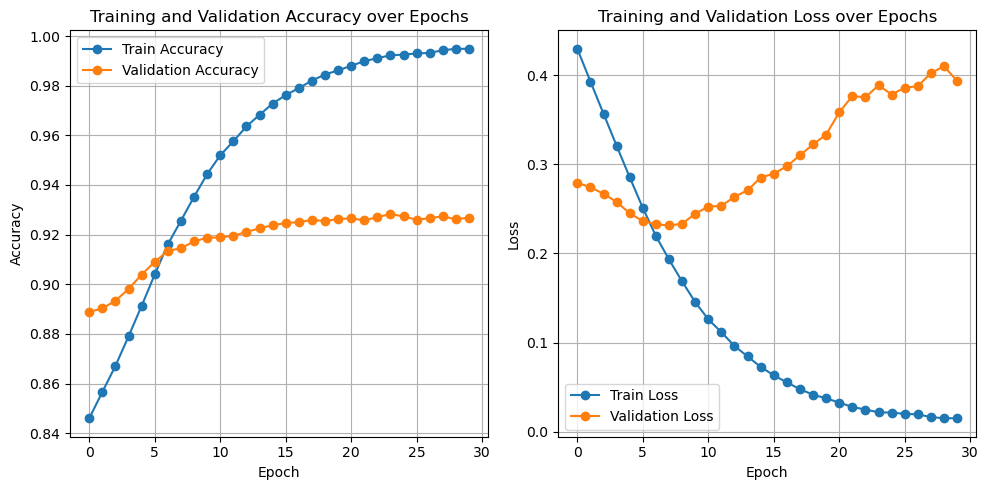

In [90]:
test_model_accuracy(model)

## Adding Batch Normalization
### Only 1 Batch Normalization Layer After Second LSTM

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    LSTM(128, activation='tanh'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 11, 256)           325632    
                                                                 
 lstm_58 (LSTM)              (None, 128)               197120    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_122 (Dense)           (None, 16)                2064      
                                                                 
 dense_123 (Dense)           (None, 16)                272       
                                                                 
 dense_124 (Dense)           (None, 16)                272       
                                                     

In [92]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 21s 68ms/step - loss: 0.3710 - accuracy: 0.8588 - val_loss: 0.3140 - val_accuracy: 0.8931
Epoch 2/30
175/175 [==============================] - 13s 74ms/step - loss: 0.2420 - accuracy: 0.8983 - val_loss: 0.2388 - val_accuracy: 0.9046
Epoch 3/30
175/175 [==============================] - 14s 80ms/step - loss: 0.2004 - accuracy: 0.9164 - val_loss: 0.2117 - val_accuracy: 0.9207
Epoch 4/30
175/175 [==============================] - 14s 82ms/step - loss: 0.1581 - accuracy: 0.9346 - val_loss: 0.2019 - val_accuracy: 0.9253
Epoch 5/30
175/175 [==============================] - 15s 83ms/step - loss: 0.1369 - accuracy: 0.9463 - val_loss: 0.2401 - val_accuracy: 0.9235
Epoch 6/30
175/175 [==============================] - 14s 79ms/step - loss: 0.1222 - accuracy: 0.9538 - val_loss: 0.2274 - val_accuracy: 0.9242
Epoch 7/30
175/175 [==============================] - 14s 79ms/step - loss: 0.0997 - accuracy: 0.9633 - val_loss: 0.2258 - val_accuracy:

110/110 [==============================] - 2s 16ms/step - loss: 0.2772 - accuracy: 0.9402
Test Accuracy: 94.0234%


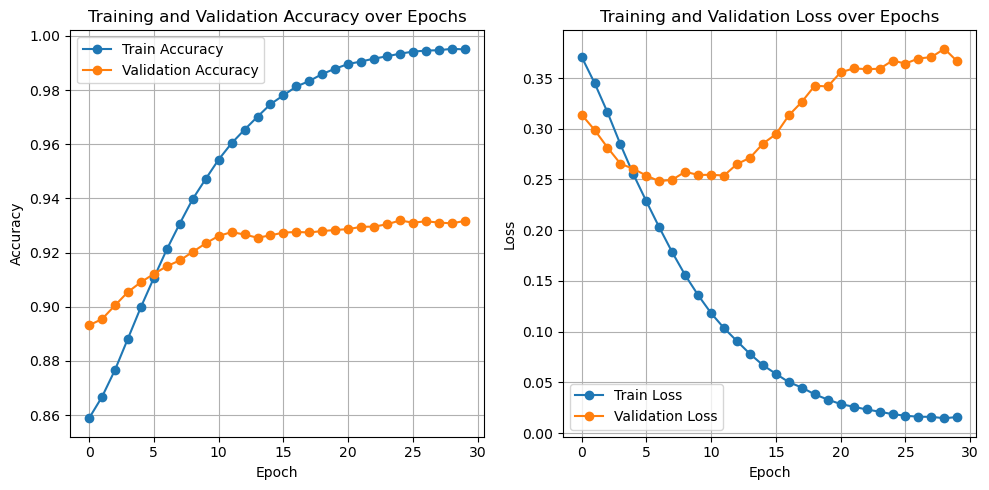

In [93]:
test_model_accuracy(model)

## Adding Batch Normalization
### Two Batch Normalization Layer After LSTMs

In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_2 (Batc  (None, 11, 256)          1024      
 hNormalization)                                                 
                                                                 
 lstm_60 (LSTM)              (None, 128)               197120    
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_127 (Dense)           (None, 16)                2064      
                                                                 
 dense_128 (Dense)           (None, 16)              

In [95]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 21s 78ms/step - loss: 0.3844 - accuracy: 0.8524 - val_loss: 0.3136 - val_accuracy: 0.8867
Epoch 2/30
175/175 [==============================] - 14s 79ms/step - loss: 0.2579 - accuracy: 0.8949 - val_loss: 0.2539 - val_accuracy: 0.8971
Epoch 3/30
175/175 [==============================] - 15s 85ms/step - loss: 0.2122 - accuracy: 0.9113 - val_loss: 0.2252 - val_accuracy: 0.9110
Epoch 4/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1884 - accuracy: 0.9223 - val_loss: 0.2433 - val_accuracy: 0.8939
Epoch 5/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1572 - accuracy: 0.9375 - val_loss: 0.2183 - val_accuracy: 0.9239
Epoch 6/30
175/175 [==============================] - 16s 89ms/step - loss: 0.1371 - accuracy: 0.9426 - val_loss: 0.2313 - val_accuracy: 0.9146
Epoch 7/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1212 - accuracy: 0.9514 - val_loss: 0.2344 - val_accuracy:

110/110 [==============================] - 2s 17ms/step - loss: 0.3738 - accuracy: 0.9297
Test Accuracy: 92.9654%


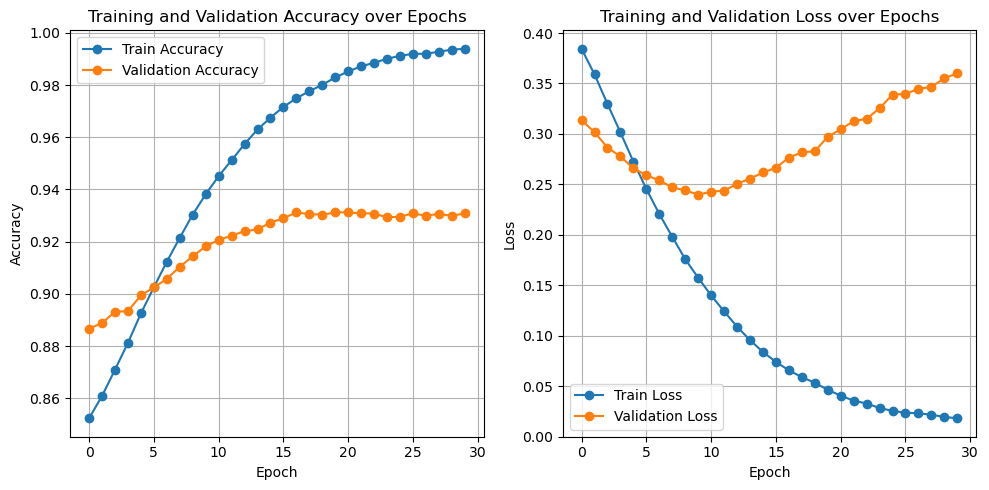

In [96]:
test_model_accuracy(model)

## Adding Pooling Layers
### Testing Average Pooling Layers

In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
     GlobalAveragePooling1D(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_5 (Batc  (None, 11, 256)          1024      
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, 5, 256)           0         
 ooling1D)                                                       
                                                                 
 lstm_63 (LSTM)              (None, 5, 128)            197120    
                                                                 
 batch_normalization_6 (Batc  (None, 5, 128)           512       
 hNormalization)                                                 
                                                     

In [99]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 35s 60ms/step - loss: 0.5264 - accuracy: 0.8004 - val_loss: 0.4489 - val_accuracy: 0.8367
Epoch 2/30
175/175 [==============================] - 12s 70ms/step - loss: 0.2743 - accuracy: 0.8865 - val_loss: 0.2529 - val_accuracy: 0.8953
Epoch 3/30
175/175 [==============================] - 12s 71ms/step - loss: 0.2142 - accuracy: 0.9102 - val_loss: 0.2252 - val_accuracy: 0.9167
Epoch 4/30
175/175 [==============================] - 12s 69ms/step - loss: 0.1781 - accuracy: 0.9282 - val_loss: 0.2736 - val_accuracy: 0.9017
Epoch 5/30
175/175 [==============================] - 12s 68ms/step - loss: 0.1479 - accuracy: 0.9410 - val_loss: 0.2316 - val_accuracy: 0.9224
Epoch 6/30
175/175 [==============================] - 12s 71ms/step - loss: 0.1259 - accuracy: 0.9521 - val_loss: 0.2326 - val_accuracy: 0.9207
Epoch 7/30
175/175 [==============================] - 14s 81ms/step - loss: 0.1034 - accuracy: 0.9600 - val_loss: 0.2146 - val_accuracy:

110/110 [==============================] - 2s 16ms/step - loss: 0.3812 - accuracy: 0.9236
Test Accuracy: 92.3649%


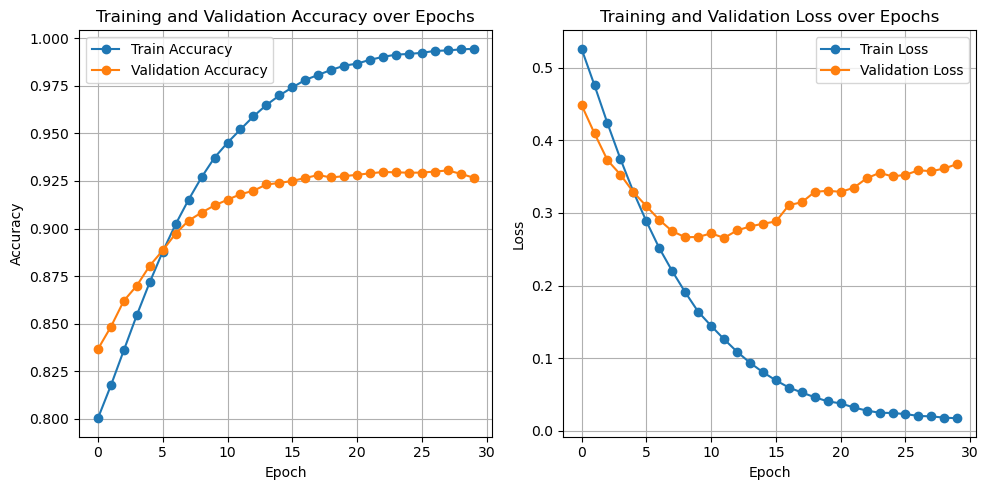

In [100]:
test_model_accuracy(model)

## Adding Pooling Layers
### Testing Average Pooling Layers (With Lower Kernel Size)

In [107]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    
    LSTM(32, activation='tanh',return_sequences=True),
    BatchNormalization(),
     GlobalAveragePooling1D(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 11, 64)            32256     
                                                                 
 batch_normalization_12 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_2 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                                 
 lstm_70 (LSTM)              (None, 5, 32)             12416     
                                                                 
 batch_normalization_13 (Bat  (None, 5, 32)            128       
 chNormalization)                                                
                                                     

In [108]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 42s 35ms/step - loss: 0.5570 - accuracy: 0.7800 - val_loss: 0.4957 - val_accuracy: 0.8567
Epoch 2/30
175/175 [==============================] - 5s 27ms/step - loss: 0.3058 - accuracy: 0.8776 - val_loss: 0.2954 - val_accuracy: 0.8821
Epoch 3/30
175/175 [==============================] - 4s 20ms/step - loss: 0.2511 - accuracy: 0.8945 - val_loss: 0.2747 - val_accuracy: 0.8860
Epoch 4/30
175/175 [==============================] - 4s 21ms/step - loss: 0.2228 - accuracy: 0.9038 - val_loss: 0.2544 - val_accuracy: 0.8863
Epoch 5/30
175/175 [==============================] - 5s 28ms/step - loss: 0.1884 - accuracy: 0.9194 - val_loss: 0.2470 - val_accuracy: 0.9089
Epoch 6/30
175/175 [==============================] - 5s 29ms/step - loss: 0.1682 - accuracy: 0.9277 - val_loss: 0.2368 - val_accuracy: 0.9107
Epoch 7/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1504 - accuracy: 0.9405 - val_loss: 0.2506 - val_accuracy: 0.889

110/110 [==============================] - 2s 10ms/step - loss: 0.4536 - accuracy: 0.9145
Test Accuracy: 91.4498%


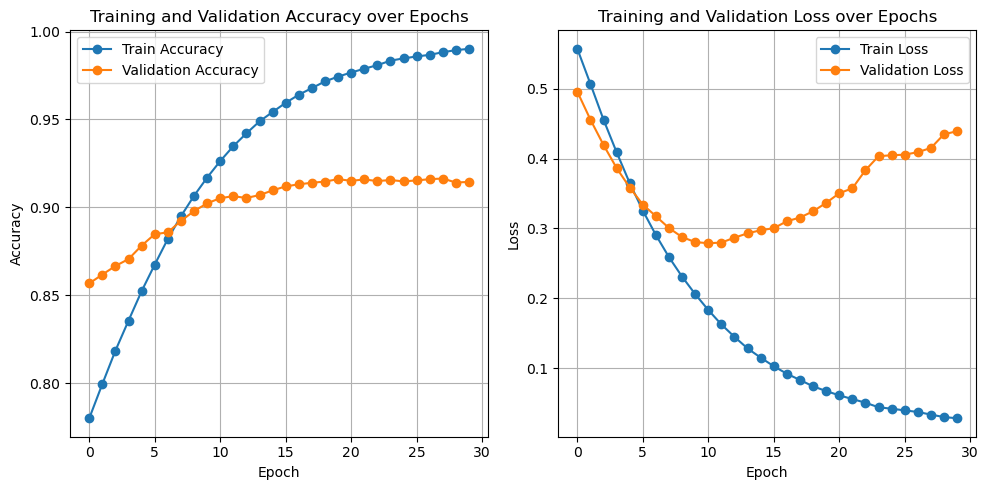

In [109]:
test_model_accuracy(model)

## Adding Pooling Layers
### Testing Max Pooling Layers

In [103]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_8 (Batc  (None, 11, 256)          1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 256)           0         
 )                                                               
                                                                 
 lstm_66 (LSTM)              (None, 5, 128)            197120    
                                                                 
 batch_normalization_9 (Batc  (None, 5, 128)           512       
 hNormalization)                                                 
                                                     

In [104]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 26s 72ms/step - loss: 0.4763 - accuracy: 0.7692 - val_loss: 0.3866 - val_accuracy: 0.8799
Epoch 2/30
175/175 [==============================] - 10s 56ms/step - loss: 0.2518 - accuracy: 0.8947 - val_loss: 0.2400 - val_accuracy: 0.9039
Epoch 3/30
175/175 [==============================] - 13s 72ms/step - loss: 0.1967 - accuracy: 0.9181 - val_loss: 0.2268 - val_accuracy: 0.9164
Epoch 4/30
175/175 [==============================] - 13s 72ms/step - loss: 0.1595 - accuracy: 0.9355 - val_loss: 0.2130 - val_accuracy: 0.9232
Epoch 5/30
175/175 [==============================] - 13s 77ms/step - loss: 0.1410 - accuracy: 0.9448 - val_loss: 0.2282 - val_accuracy: 0.9114
Epoch 6/30
175/175 [==============================] - 13s 71ms/step - loss: 0.1128 - accuracy: 0.9558 - val_loss: 0.2120 - val_accuracy: 0.9121
Epoch 7/30
175/175 [==============================] - 12s 69ms/step - loss: 0.0951 - accuracy: 0.9632 - val_loss: 0.2036 - val_accuracy:

110/110 [==============================] - 2s 20ms/step - loss: 0.2934 - accuracy: 0.9371
Test Accuracy: 93.7089%


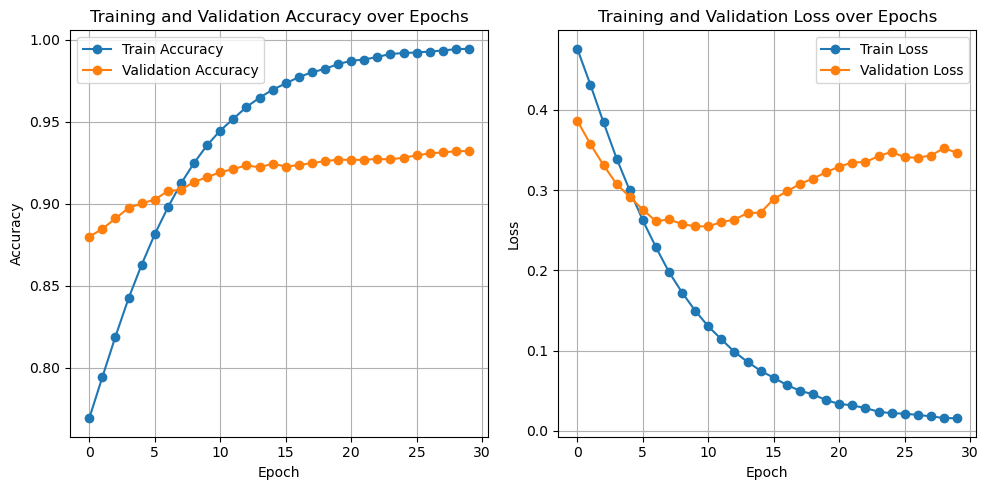

In [105]:
test_model_accuracy(model)

## Adding Pooling Layers
### Testing Max Pooling Layers (With Lower Kernel Size)

In [110]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    LSTM(32, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_71 (LSTM)              (None, 11, 64)            32256     
                                                                 
 batch_normalization_14 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 lstm_72 (LSTM)              (None, 5, 32)             12416     
                                                                 
 batch_normalization_15 (Bat  (None, 5, 32)            128       
 chNormalization)                                                
                                                     

In [111]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 17s 32ms/step - loss: 0.5773 - accuracy: 0.7488 - val_loss: 0.4244 - val_accuracy: 0.8796
Epoch 2/30
175/175 [==============================] - 3s 19ms/step - loss: 0.2711 - accuracy: 0.8862 - val_loss: 0.2590 - val_accuracy: 0.8996
Epoch 3/30
175/175 [==============================] - 3s 18ms/step - loss: 0.2221 - accuracy: 0.9074 - val_loss: 0.2371 - val_accuracy: 0.9024
Epoch 4/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1883 - accuracy: 0.9189 - val_loss: 0.2295 - val_accuracy: 0.9103
Epoch 5/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1609 - accuracy: 0.9325 - val_loss: 0.2336 - val_accuracy: 0.9124
Epoch 6/30
175/175 [==============================] - 4s 21ms/step - loss: 0.1380 - accuracy: 0.9433 - val_loss: 0.2215 - val_accuracy: 0.9164
Epoch 7/30
175/175 [==============================] - 3s 19ms/step - loss: 0.1223 - accuracy: 0.9487 - val_loss: 0.2391 - val_accuracy: 0.915

110/110 [==============================] - 1s 6ms/step - loss: 0.4383 - accuracy: 0.9174
Test Accuracy: 91.7358%


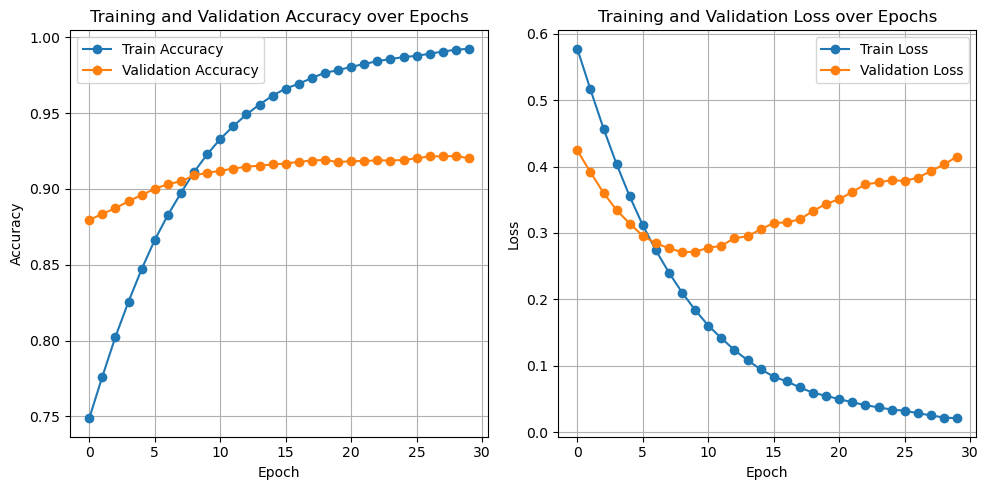

In [112]:
test_model_accuracy(model)

## Adding Dropout Layers
### Max Pooling Layer Architecture

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_73 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_16 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 256)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 lstm_74 (LSTM)              (None, 5, 128)            197120    
                                                                 
 batch_normalization_17 (Bat  (None, 5, 128)         

In [114]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 22s 75ms/step - loss: 0.7619 - accuracy: 0.6312 - val_loss: 0.4968 - val_accuracy: 0.8624
Epoch 2/30
175/175 [==============================] - 12s 68ms/step - loss: 0.4874 - accuracy: 0.8206 - val_loss: 0.3376 - val_accuracy: 0.8749
Epoch 3/30
175/175 [==============================] - 13s 74ms/step - loss: 0.4283 - accuracy: 0.8470 - val_loss: 0.3252 - val_accuracy: 0.8749
Epoch 4/30
175/175 [==============================] - 13s 75ms/step - loss: 0.3664 - accuracy: 0.8686 - val_loss: 0.2816 - val_accuracy: 0.8960
Epoch 5/30
175/175 [==============================] - 13s 72ms/step - loss: 0.3341 - accuracy: 0.8782 - val_loss: 0.2868 - val_accuracy: 0.8953
Epoch 6/30
175/175 [==============================] - 13s 75ms/step - loss: 0.3144 - accuracy: 0.8907 - val_loss: 0.2655 - val_accuracy: 0.9074
Epoch 7/30
175/175 [==============================] - 14s 78ms/step - loss: 0.2734 - accuracy: 0.9053 - val_loss: 0.2731 - val_accuracy:

110/110 [==============================] - 2s 16ms/step - loss: 0.3231 - accuracy: 0.9299
Test Accuracy: 92.9940%


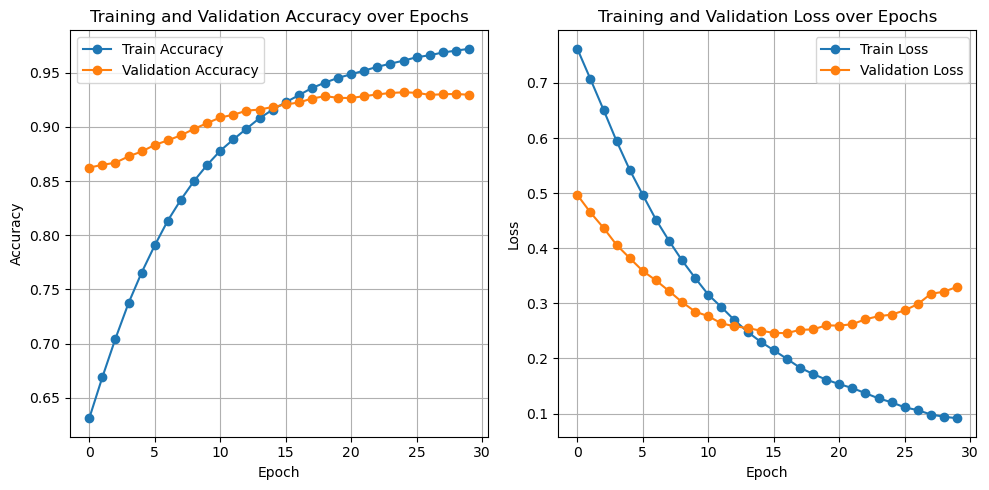

In [115]:
test_model_accuracy(model)

## Adding Dropout Layers
### Average Pooling Layer Architecture

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_18 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_3 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                                 
 dropout_6 (Dropout)         (None, 5, 256)            0         
                                                                 
 lstm_76 (LSTM)              (None, 5, 128)            197120    
                                                                 
 batch_normalization_19 (Bat  (None, 5, 128)         

In [117]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 21s 72ms/step - loss: 0.8628 - accuracy: 0.5627 - val_loss: 0.6291 - val_accuracy: 0.8438
Epoch 2/30
175/175 [==============================] - 11s 64ms/step - loss: 0.5457 - accuracy: 0.7930 - val_loss: 0.3484 - val_accuracy: 0.8656
Epoch 3/30
175/175 [==============================] - 13s 75ms/step - loss: 0.4277 - accuracy: 0.8444 - val_loss: 0.3257 - val_accuracy: 0.8692
Epoch 4/30
175/175 [==============================] - 13s 74ms/step - loss: 0.3739 - accuracy: 0.8656 - val_loss: 0.3224 - val_accuracy: 0.8742
Epoch 5/30
175/175 [==============================] - 13s 76ms/step - loss: 0.3365 - accuracy: 0.8802 - val_loss: 0.2670 - val_accuracy: 0.8967
Epoch 6/30
175/175 [==============================] - 13s 72ms/step - loss: 0.2951 - accuracy: 0.8948 - val_loss: 0.2435 - val_accuracy: 0.9107
Epoch 7/30
175/175 [==============================] - 13s 73ms/step - loss: 0.2765 - accuracy: 0.9038 - val_loss: 0.2771 - val_accuracy:

110/110 [==============================] - 5s 28ms/step - loss: 0.4364 - accuracy: 0.9242
Test Accuracy: 92.4221%


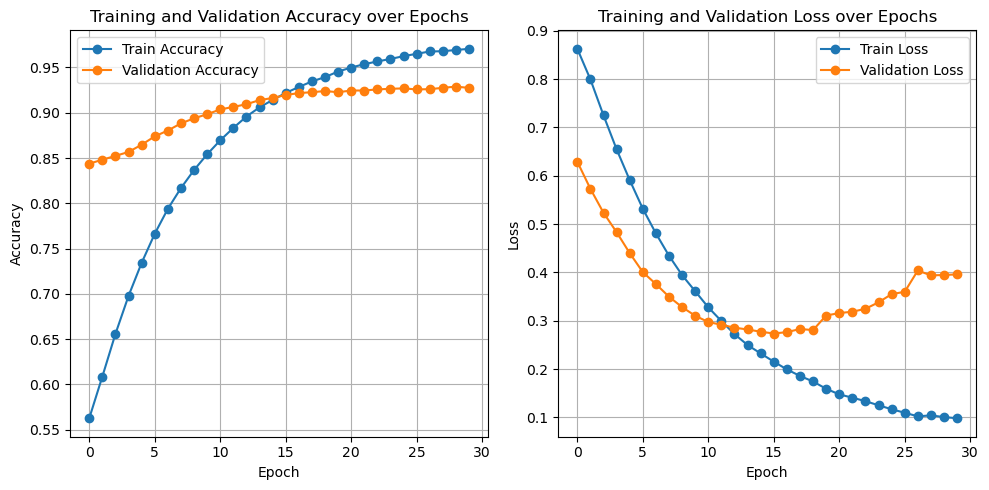

In [118]:
test_model_accuracy(model)

## Complex Architecture
### Tested with Max Pooling Layers

In [119]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_20 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_78 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_21 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 5, 256)           0         
 1D)                                                             
                                                     

In [120]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 51s 160ms/step - loss: 0.8155 - accuracy: 0.6116 - val_loss: 0.6532 - val_accuracy: 0.8177
Epoch 2/30
175/175 [==============================] - 26s 146ms/step - loss: 0.5647 - accuracy: 0.7962 - val_loss: 0.4356 - val_accuracy: 0.8374
Epoch 3/30
175/175 [==============================] - 27s 157ms/step - loss: 0.4721 - accuracy: 0.8312 - val_loss: 0.3404 - val_accuracy: 0.8688
Epoch 4/30
175/175 [==============================] - 27s 154ms/step - loss: 0.3926 - accuracy: 0.8570 - val_loss: 0.3490 - val_accuracy: 0.8488
Epoch 5/30
175/175 [==============================] - 27s 153ms/step - loss: 0.3777 - accuracy: 0.8626 - val_loss: 0.3567 - val_accuracy: 0.8817
Epoch 6/30
175/175 [==============================] - 26s 150ms/step - loss: 0.3169 - accuracy: 0.8850 - val_loss: 0.2609 - val_accuracy: 0.8942
Epoch 7/30
175/175 [==============================] - 27s 152ms/step - loss: 0.2765 - accuracy: 0.9003 - val_loss: 0.2970 - val_ac

110/110 [==============================] - 4s 37ms/step - loss: 0.3154 - accuracy: 0.9328
Test Accuracy: 93.2800%


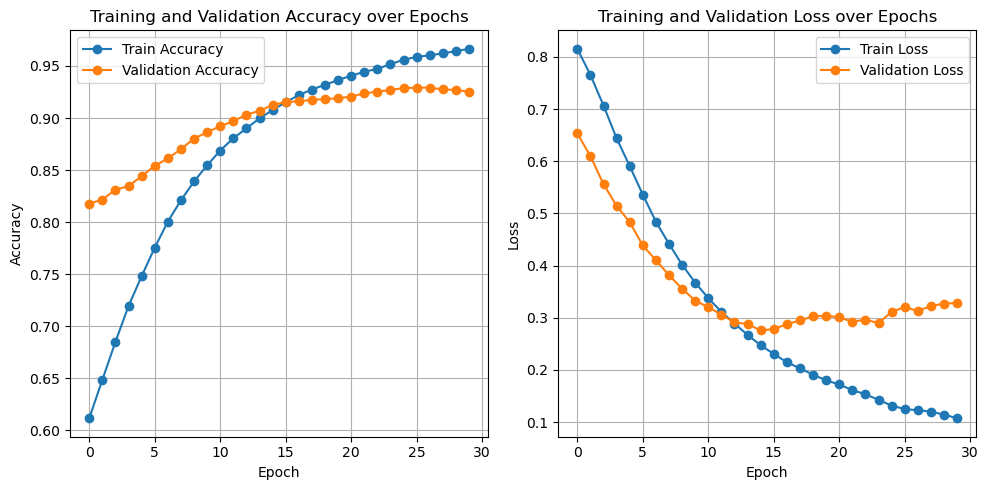

In [121]:
test_model_accuracy(model)

## Complex Architecture
### Tested with Max Pooling Layers (Lower Kernel Size)

In [122]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(32, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(32, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_81 (LSTM)              (None, 11, 64)            32256     
                                                                 
 batch_normalization_24 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_82 (LSTM)              (None, 11, 64)            33024     
                                                                 
 batch_normalization_25 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                     

In [123]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 26s 56ms/step - loss: 1.0276 - accuracy: 0.4824 - val_loss: 0.9900 - val_accuracy: 0.5404
Epoch 2/30
175/175 [==============================] - 6s 35ms/step - loss: 0.7909 - accuracy: 0.7176 - val_loss: 0.5255 - val_accuracy: 0.8606
Epoch 3/30
175/175 [==============================] - 6s 33ms/step - loss: 0.5363 - accuracy: 0.8194 - val_loss: 0.4130 - val_accuracy: 0.8556
Epoch 4/30
175/175 [==============================] - 8s 43ms/step - loss: 0.4461 - accuracy: 0.8432 - val_loss: 0.3336 - val_accuracy: 0.8781
Epoch 5/30
175/175 [==============================] - 7s 39ms/step - loss: 0.3934 - accuracy: 0.8622 - val_loss: 0.2974 - val_accuracy: 0.8924
Epoch 6/30
175/175 [==============================] - 8s 43ms/step - loss: 0.3498 - accuracy: 0.8744 - val_loss: 0.2804 - val_accuracy: 0.8992
Epoch 7/30
175/175 [==============================] - 7s 41ms/step - loss: 0.3129 - accuracy: 0.8898 - val_loss: 0.2837 - val_accuracy: 0.897

110/110 [==============================] - 2s 14ms/step - loss: 0.3798 - accuracy: 0.9228
Test Accuracy: 92.2791%


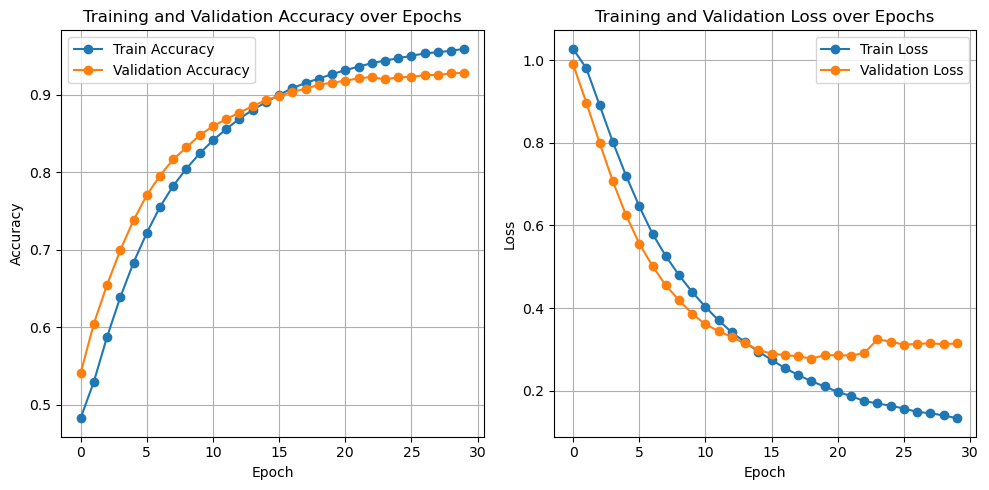

In [124]:
test_model_accuracy(model)

## Complex Architecture
### Tested with Average Pooling Layers

In [125]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_85 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_28 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_86 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_29 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_4 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                     

In [126]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 44s 156ms/step - loss: 0.8192 - accuracy: 0.6169 - val_loss: 0.6789 - val_accuracy: 0.7766
Epoch 2/30
175/175 [==============================] - 27s 156ms/step - loss: 0.5672 - accuracy: 0.7888 - val_loss: 0.4598 - val_accuracy: 0.8463
Epoch 3/30
175/175 [==============================] - 26s 151ms/step - loss: 0.4703 - accuracy: 0.8298 - val_loss: 0.4025 - val_accuracy: 0.8570
Epoch 4/30
175/175 [==============================] - 28s 161ms/step - loss: 0.4096 - accuracy: 0.8558 - val_loss: 0.3251 - val_accuracy: 0.8778
Epoch 5/30
175/175 [==============================] - 27s 153ms/step - loss: 0.3680 - accuracy: 0.8677 - val_loss: 0.3044 - val_accuracy: 0.8899
Epoch 6/30
175/175 [==============================] - 26s 150ms/step - loss: 0.3466 - accuracy: 0.8783 - val_loss: 0.2965 - val_accuracy: 0.9017
Epoch 7/30
175/175 [==============================] - 28s 158ms/step - loss: 0.3213 - accuracy: 0.8900 - val_loss: 0.2717 - val_ac

110/110 [==============================] - 4s 35ms/step - loss: 0.3238 - accuracy: 0.9388
Test Accuracy: 93.8805%


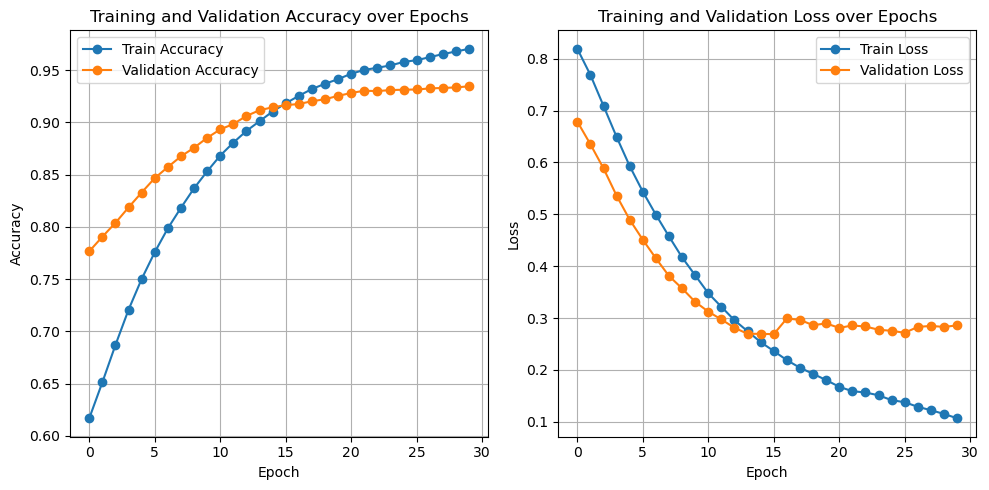

In [127]:
test_model_accuracy(model)

## Complex Architecture
### Tested with Average Pooling Layers (Lower Kernel Size)

In [128]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(32, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(32, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_89 (LSTM)              (None, 11, 64)            32256     
                                                                 
 batch_normalization_32 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_90 (LSTM)              (None, 11, 64)            33024     
                                                                 
 batch_normalization_33 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_5 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                     

In [129]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 23s 48ms/step - loss: 0.9219 - accuracy: 0.5173 - val_loss: 0.8565 - val_accuracy: 0.5893
Epoch 2/30
175/175 [==============================] - 7s 38ms/step - loss: 0.6613 - accuracy: 0.7123 - val_loss: 0.5308 - val_accuracy: 0.8102
Epoch 3/30
175/175 [==============================] - 6s 34ms/step - loss: 0.5345 - accuracy: 0.7925 - val_loss: 0.4528 - val_accuracy: 0.8231
Epoch 4/30
175/175 [==============================] - 7s 41ms/step - loss: 0.4683 - accuracy: 0.8239 - val_loss: 0.3581 - val_accuracy: 0.8620
Epoch 5/30
175/175 [==============================] - 8s 45ms/step - loss: 0.4018 - accuracy: 0.8534 - val_loss: 0.3124 - val_accuracy: 0.8810
Epoch 6/30
175/175 [==============================] - 7s 40ms/step - loss: 0.3677 - accuracy: 0.8634 - val_loss: 0.3066 - val_accuracy: 0.8842
Epoch 7/30
175/175 [==============================] - 8s 43ms/step - loss: 0.3411 - accuracy: 0.8727 - val_loss: 0.2925 - val_accuracy: 0.881

110/110 [==============================] - 1s 11ms/step - loss: 0.3618 - accuracy: 0.9162
Test Accuracy: 91.6214%


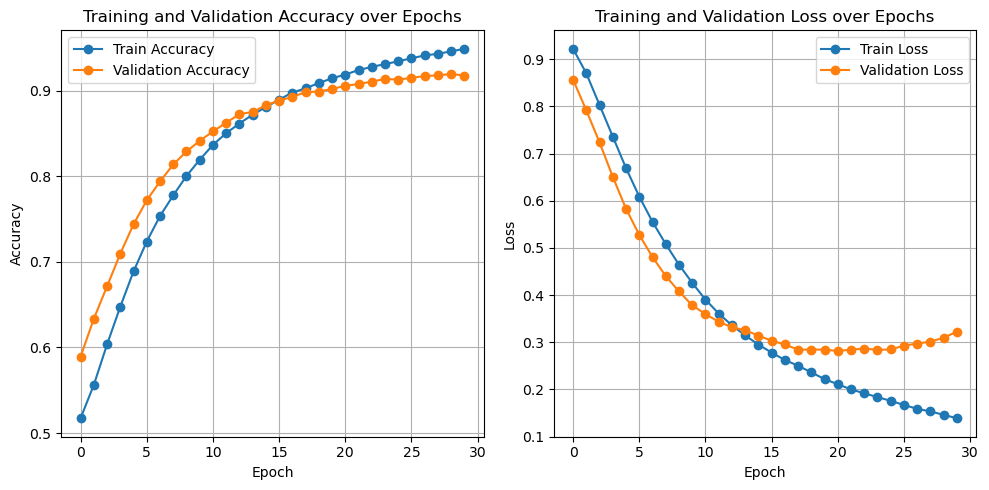

In [130]:
test_model_accuracy(model)

## Tweaking the Complex Model
### Tested with Max Pooling Layers

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_93 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_36 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_94 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_37 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 5, 256)           0         
 1D)                                                             
                                                     

In [133]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 45s 175ms/step - loss: 1.0326 - accuracy: 0.4664 - val_loss: 0.8852 - val_accuracy: 0.6179
Epoch 2/30
175/175 [==============================] - 34s 192ms/step - loss: 0.7020 - accuracy: 0.6803 - val_loss: 0.4243 - val_accuracy: 0.8327
Epoch 3/30
175/175 [==============================] - 37s 208ms/step - loss: 0.5750 - accuracy: 0.7687 - val_loss: 0.3881 - val_accuracy: 0.8545
Epoch 4/30
175/175 [==============================] - 37s 209ms/step - loss: 0.4880 - accuracy: 0.8132 - val_loss: 0.3596 - val_accuracy: 0.8774
Epoch 5/30
175/175 [==============================] - 32s 182ms/step - loss: 0.4497 - accuracy: 0.8345 - val_loss: 0.3385 - val_accuracy: 0.8810
Epoch 6/30
175/175 [==============================] - 32s 185ms/step - loss: 0.4134 - accuracy: 0.8446 - val_loss: 0.2950 - val_accuracy: 0.8910
Epoch 7/30
175/175 [==============================] - 34s 193ms/step - loss: 0.3790 - accuracy: 0.8642 - val_loss: 0.3098 - val_ac

110/110 [==============================] - 4s 32ms/step - loss: 0.3345 - accuracy: 0.9337
Test Accuracy: 93.3657%


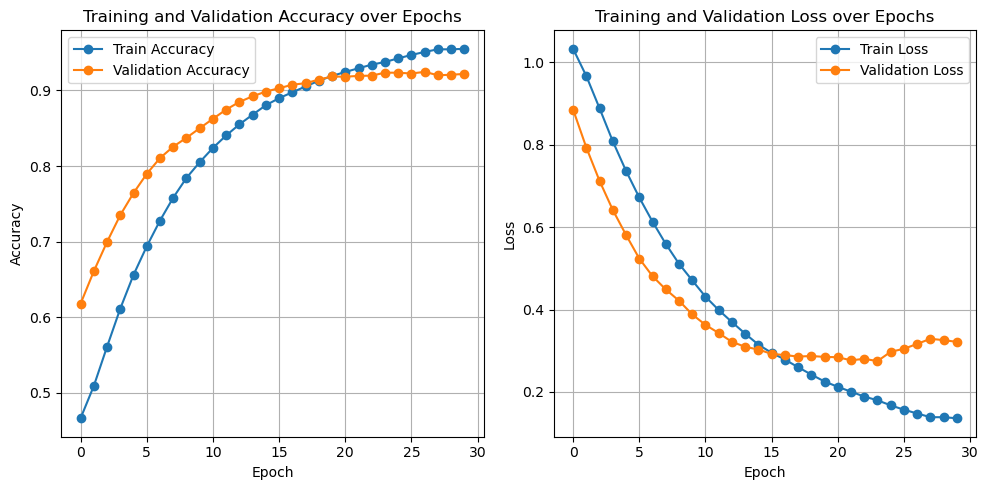

In [134]:
test_model_accuracy(model)

## Tweaked Complex Architecture
### Tested with Max Pooling Layers (Lower Kernel Size)

In [135]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(32, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(32, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_97 (LSTM)              (None, 11, 64)            32256     
                                                                 
 batch_normalization_40 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_98 (LSTM)              (None, 11, 64)            33024     
                                                                 
 batch_normalization_41 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                     

In [136]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 25s 56ms/step - loss: 1.0846 - accuracy: 0.3926 - val_loss: 1.0387 - val_accuracy: 0.5865
Epoch 2/30
175/175 [==============================] - 6s 34ms/step - loss: 0.7805 - accuracy: 0.6319 - val_loss: 0.5251 - val_accuracy: 0.8327
Epoch 3/30
175/175 [==============================] - 6s 35ms/step - loss: 0.5968 - accuracy: 0.7781 - val_loss: 0.4063 - val_accuracy: 0.8588
Epoch 4/30
175/175 [==============================] - 8s 44ms/step - loss: 0.5139 - accuracy: 0.8145 - val_loss: 0.3656 - val_accuracy: 0.8631
Epoch 5/30
175/175 [==============================] - 8s 46ms/step - loss: 0.4465 - accuracy: 0.8397 - val_loss: 0.3360 - val_accuracy: 0.8774
Epoch 6/30
175/175 [==============================] - 8s 44ms/step - loss: 0.4150 - accuracy: 0.8486 - val_loss: 0.3587 - val_accuracy: 0.8642
Epoch 7/30
175/175 [==============================] - 7s 38ms/step - loss: 0.3917 - accuracy: 0.8592 - val_loss: 0.3092 - val_accuracy: 0.883

110/110 [==============================] - 2s 14ms/step - loss: 0.3837 - accuracy: 0.9165
Test Accuracy: 91.6500%


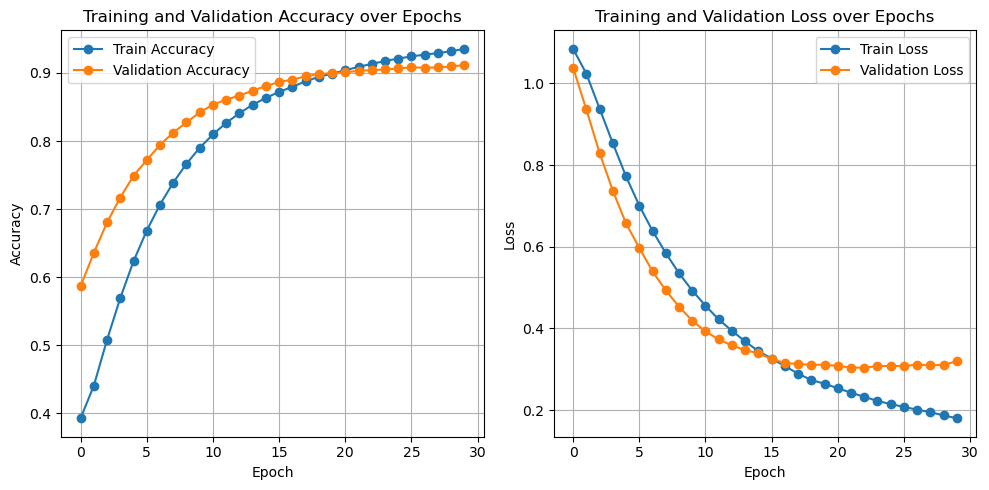

In [137]:
test_model_accuracy(model)

## Tweaked Complex Architecture
### Tested with Average Pooling Layers 

In [138]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_101 (LSTM)             (None, 11, 256)           325632    
                                                                 
 batch_normalization_44 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_102 (LSTM)             (None, 11, 256)           525312    
                                                                 
 batch_normalization_45 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_6 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                     

In [139]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 42s 161ms/step - loss: 1.0079 - accuracy: 0.4737 - val_loss: 0.8296 - val_accuracy: 0.6637
Epoch 2/30
175/175 [==============================] - 27s 153ms/step - loss: 0.7202 - accuracy: 0.7397 - val_loss: 0.5257 - val_accuracy: 0.8388
Epoch 3/30
175/175 [==============================] - 28s 158ms/step - loss: 0.5593 - accuracy: 0.7990 - val_loss: 0.4197 - val_accuracy: 0.8578
Epoch 4/30
175/175 [==============================] - 30s 169ms/step - loss: 0.5184 - accuracy: 0.8124 - val_loss: 0.3903 - val_accuracy: 0.8503
Epoch 5/30
175/175 [==============================] - 30s 174ms/step - loss: 0.4396 - accuracy: 0.8441 - val_loss: 0.3532 - val_accuracy: 0.8760
Epoch 6/30
175/175 [==============================] - 31s 178ms/step - loss: 0.3972 - accuracy: 0.8565 - val_loss: 0.3351 - val_accuracy: 0.8935
Epoch 7/30
175/175 [==============================] - 27s 153ms/step - loss: 0.3664 - accuracy: 0.8651 - val_loss: 0.3130 - val_ac

110/110 [==============================] - 3s 28ms/step - loss: 0.4069 - accuracy: 0.9314
Test Accuracy: 93.1370%


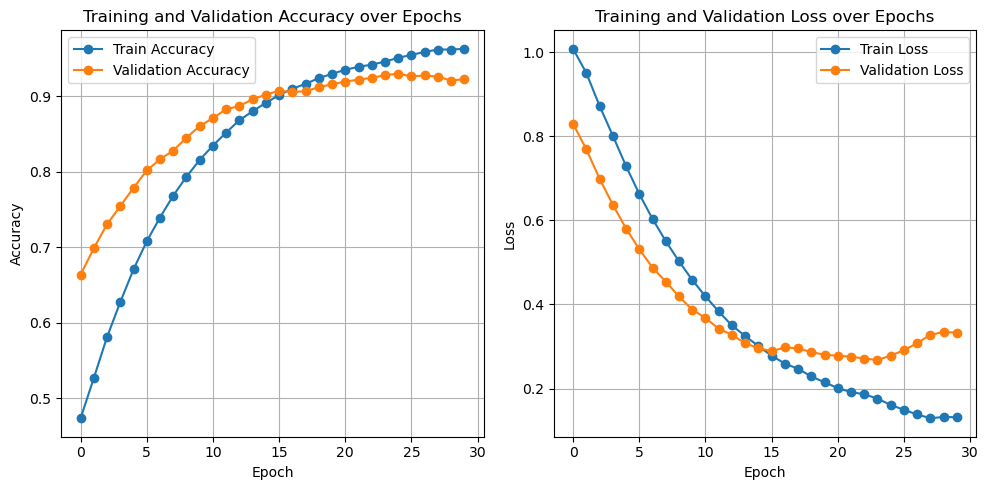

In [140]:
test_model_accuracy(model)

## Tweaked Complex Architecture
### Tested with Average Pooling Layer (Lower Kernel Size)

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(32, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(32, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_105 (LSTM)             (None, 11, 64)            32256     
                                                                 
 batch_normalization_48 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_106 (LSTM)             (None, 11, 64)            33024     
                                                                 
 batch_normalization_49 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_7 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                     

In [142]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 25s 59ms/step - loss: 1.0540 - accuracy: 0.4202 - val_loss: 1.0089 - val_accuracy: 0.5897
Epoch 2/30
175/175 [==============================] - 7s 38ms/step - loss: 0.7091 - accuracy: 0.7029 - val_loss: 0.5140 - val_accuracy: 0.8084
Epoch 3/30
175/175 [==============================] - 9s 50ms/step - loss: 0.5762 - accuracy: 0.7743 - val_loss: 0.4594 - val_accuracy: 0.8120
Epoch 4/30
175/175 [==============================] - 8s 47ms/step - loss: 0.4955 - accuracy: 0.8096 - val_loss: 0.4021 - val_accuracy: 0.8556
Epoch 5/30
175/175 [==============================] - 8s 45ms/step - loss: 0.4355 - accuracy: 0.8333 - val_loss: 0.3706 - val_accuracy: 0.8635
Epoch 6/30
175/175 [==============================] - 7s 38ms/step - loss: 0.4140 - accuracy: 0.8502 - val_loss: 0.3474 - val_accuracy: 0.8746
Epoch 7/30
175/175 [==============================] - 8s 48ms/step - loss: 0.3676 - accuracy: 0.8649 - val_loss: 0.3146 - val_accuracy: 0.888

110/110 [==============================] - 2s 12ms/step - loss: 0.3052 - accuracy: 0.9216
Test Accuracy: 92.1647%


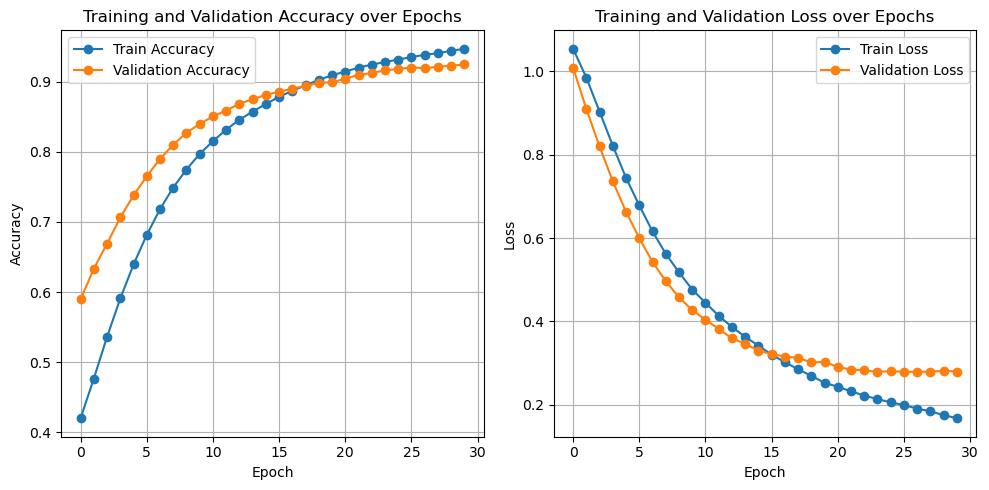

In [143]:
test_model_accuracy(model)

## Tweaked Complex Architecture (Dense Layers Adjusted)
### Tested with Average Pooling Layers 

In [147]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_113 (LSTM)             (None, 11, 256)           325632    
                                                                 
 batch_normalization_56 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_114 (LSTM)             (None, 11, 256)           525312    
                                                                 
 batch_normalization_57 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_8 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                     

In [148]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 43s 158ms/step - loss: 0.7573 - accuracy: 0.6458 - val_loss: 0.6311 - val_accuracy: 0.8063
Epoch 2/30
175/175 [==============================] - 27s 155ms/step - loss: 0.4898 - accuracy: 0.8161 - val_loss: 0.3660 - val_accuracy: 0.8517
Epoch 3/30
175/175 [==============================] - 27s 155ms/step - loss: 0.3847 - accuracy: 0.8586 - val_loss: 0.3049 - val_accuracy: 0.8792
Epoch 4/30
175/175 [==============================] - 26s 151ms/step - loss: 0.3399 - accuracy: 0.8722 - val_loss: 0.2753 - val_accuracy: 0.8981
Epoch 5/30
175/175 [==============================] - 27s 154ms/step - loss: 0.3136 - accuracy: 0.8826 - val_loss: 0.2810 - val_accuracy: 0.8838
Epoch 6/30
175/175 [==============================] - 27s 155ms/step - loss: 0.2710 - accuracy: 0.9046 - val_loss: 0.2163 - val_accuracy: 0.9174
Epoch 7/30
175/175 [==============================] - 26s 151ms/step - loss: 0.2404 - accuracy: 0.9140 - val_loss: 0.2438 - val_ac

110/110 [==============================] - 7s 33ms/step - loss: 0.3651 - accuracy: 0.9297
Test Accuracy: 92.9654%


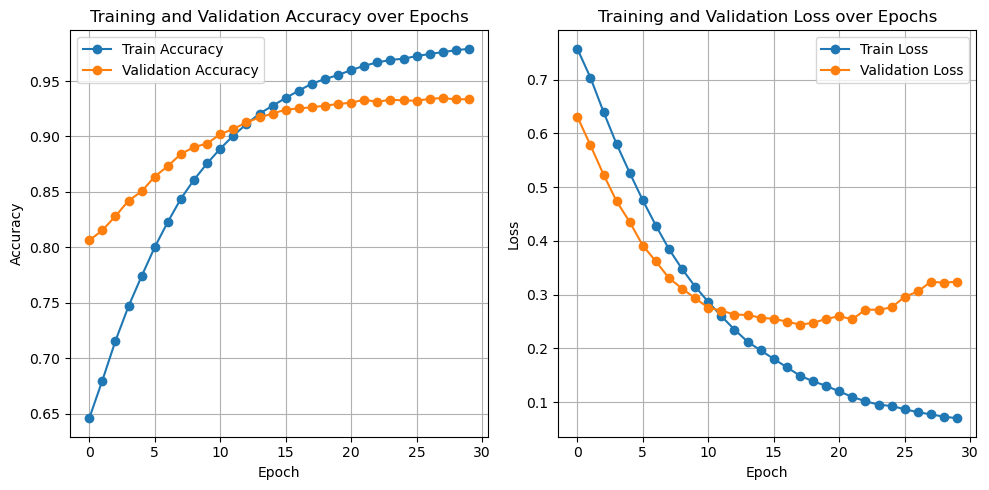

In [149]:
test_model_accuracy(model)

## Tweaked Complex Architecture (Dense Layers Adjusted)
### Tested with Max Pooling Layers 

In [150]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 11, 256)           325632    
                                                                 
 batch_normalization_60 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_118 (LSTM)             (None, 11, 256)           525312    
                                                                 
 batch_normalization_61 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 5, 256)           0         
 1D)                                                             
                                                     

In [151]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 49s 191ms/step - loss: 0.8540 - accuracy: 0.5844 - val_loss: 0.6339 - val_accuracy: 0.7916
Epoch 2/30
175/175 [==============================] - 34s 195ms/step - loss: 0.5260 - accuracy: 0.8037 - val_loss: 0.3490 - val_accuracy: 0.8663
Epoch 3/30
175/175 [==============================] - 37s 213ms/step - loss: 0.4146 - accuracy: 0.8502 - val_loss: 0.3153 - val_accuracy: 0.8846
Epoch 4/30
175/175 [==============================] - 33s 191ms/step - loss: 0.3604 - accuracy: 0.8713 - val_loss: 0.2916 - val_accuracy: 0.8813
Epoch 5/30
175/175 [==============================] - 29s 165ms/step - loss: 0.3229 - accuracy: 0.8860 - val_loss: 0.3073 - val_accuracy: 0.8885
Epoch 6/30
175/175 [==============================] - 29s 168ms/step - loss: 0.2815 - accuracy: 0.8988 - val_loss: 0.2835 - val_accuracy: 0.8896
Epoch 7/30
175/175 [==============================] - 33s 189ms/step - loss: 0.2524 - accuracy: 0.9061 - val_loss: 0.2974 - val_ac

110/110 [==============================] - 4s 32ms/step - loss: 0.3471 - accuracy: 0.9277
Test Accuracy: 92.7652%


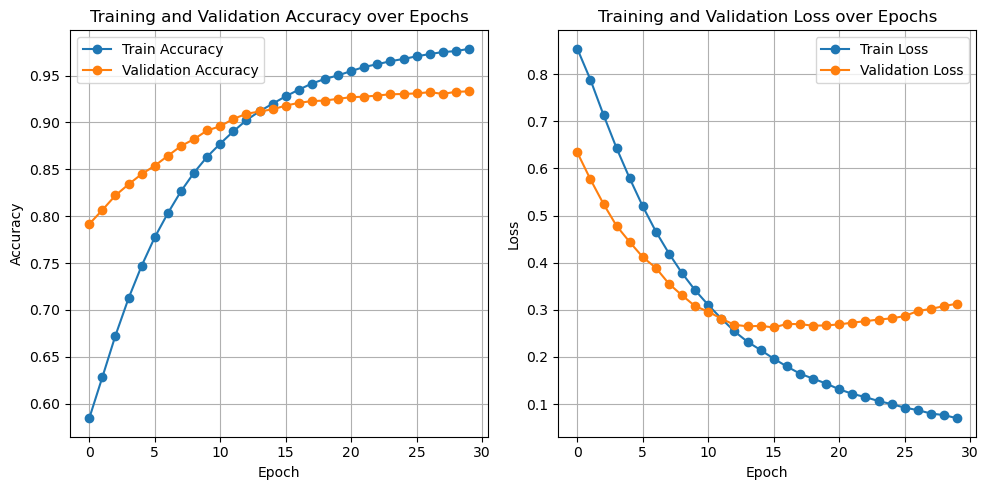

In [153]:
test_model_accuracy(model)

## More Complex Architecture
### Tested with Average Pooling Layers

In [154]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_121 (LSTM)             (None, 11, 256)           325632    
                                                                 
 batch_normalization_64 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_122 (LSTM)             (None, 11, 256)           525312    
                                                                 
 batch_normalization_65 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_123 (LSTM)             (None, 11, 256)           525312    
                                                                 
 batch_normalization_66 (Bat  (None, 11, 256)        

In [155]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 96s 344ms/step - loss: 0.8964 - accuracy: 0.5466 - val_loss: 0.8315 - val_accuracy: 0.7012
Epoch 2/30
175/175 [==============================] - 40s 229ms/step - loss: 0.6095 - accuracy: 0.7532 - val_loss: 0.4399 - val_accuracy: 0.8174
Epoch 3/30
175/175 [==============================] - 43s 245ms/step - loss: 0.5146 - accuracy: 0.8064 - val_loss: 0.3637 - val_accuracy: 0.8613
Epoch 4/30
175/175 [==============================] - 41s 232ms/step - loss: 0.4535 - accuracy: 0.8332 - val_loss: 0.3706 - val_accuracy: 0.8578
Epoch 5/30
175/175 [==============================] - 41s 232ms/step - loss: 0.3822 - accuracy: 0.8599 - val_loss: 0.3365 - val_accuracy: 0.8710
Epoch 6/30
175/175 [==============================] - 41s 233ms/step - loss: 0.3516 - accuracy: 0.8728 - val_loss: 0.2767 - val_accuracy: 0.8871
Epoch 7/30
175/175 [==============================] - 41s 236ms/step - loss: 0.3331 - accuracy: 0.8819 - val_loss: 0.2422 - val_ac

110/110 [==============================] - 7s 52ms/step - loss: 0.2845 - accuracy: 0.9297
Test Accuracy: 92.9654%


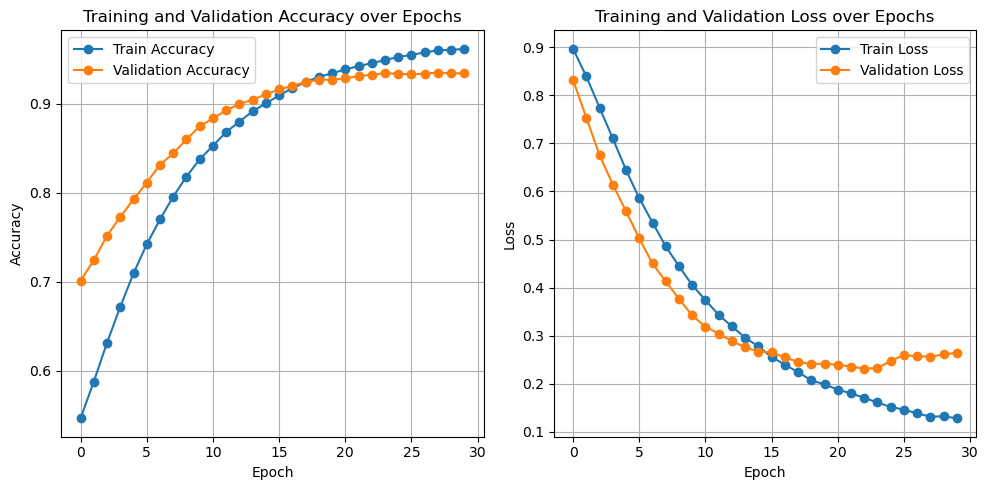

In [156]:
test_model_accuracy(model)

## More Complex Architecture
### Tested with Max Pooling Layers

In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_127 (LSTM)             (None, 11, 256)           325632    
                                                                 
 batch_normalization_70 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_128 (LSTM)             (None, 11, 256)           525312    
                                                                 
 batch_normalization_71 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_129 (LSTM)             (None, 11, 256)           525312    
                                                                 
 batch_normalization_72 (Bat  (None, 11, 256)        

In [158]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 69s 244ms/step - loss: 0.9253 - accuracy: 0.5382 - val_loss: 0.8109 - val_accuracy: 0.6912
Epoch 2/30
175/175 [==============================] - 41s 233ms/step - loss: 0.6301 - accuracy: 0.7421 - val_loss: 0.4190 - val_accuracy: 0.8345
Epoch 3/30
175/175 [==============================] - 41s 234ms/step - loss: 0.5017 - accuracy: 0.8088 - val_loss: 0.3164 - val_accuracy: 0.8721
Epoch 4/30
175/175 [==============================] - 42s 238ms/step - loss: 0.4519 - accuracy: 0.8342 - val_loss: 0.3102 - val_accuracy: 0.8910
Epoch 5/30
175/175 [==============================] - 41s 235ms/step - loss: 0.3901 - accuracy: 0.8517 - val_loss: 0.3087 - val_accuracy: 0.8896
Epoch 6/30
175/175 [==============================] - 43s 244ms/step - loss: 0.3442 - accuracy: 0.8772 - val_loss: 0.3153 - val_accuracy: 0.8824
Epoch 7/30
175/175 [==============================] - 42s 241ms/step - loss: 0.3385 - accuracy: 0.8778 - val_loss: 0.2716 - val_ac

110/110 [==============================] - 6s 53ms/step - loss: 0.2961 - accuracy: 0.9322
Test Accuracy: 93.2228%


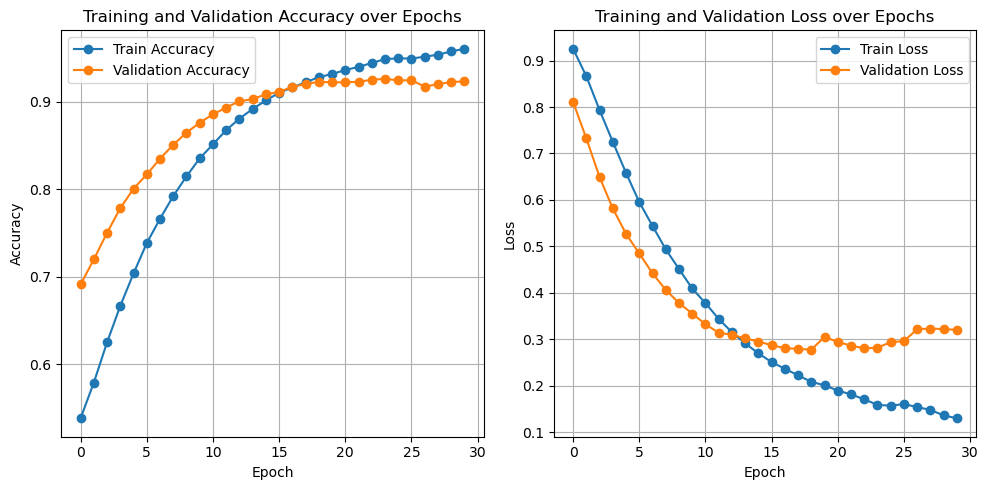

In [159]:
test_model_accuracy(model)

## Different Approach 
### Tested with Max Pooling layers

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),

    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 11, 256)           325632    
                                                                 
 batch_normalization (BatchN  (None, 11, 256)          1024      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 11, 256)           525312    
                                                                 
 batch_normalization_1 (Batc  (None, 11, 256)          1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 256)           0         
 )                                                               
                                                        

In [10]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 67s 166ms/step - loss: 0.9584 - accuracy: 0.4811 - val_loss: 0.9390 - val_accuracy: 0.6183
Epoch 2/30
175/175 [==============================] - 27s 157ms/step - loss: 0.6800 - accuracy: 0.6993 - val_loss: 0.4998 - val_accuracy: 0.8159
Epoch 3/30
175/175 [==============================] - 27s 152ms/step - loss: 0.5540 - accuracy: 0.7834 - val_loss: 0.3950 - val_accuracy: 0.8402
Epoch 4/30
175/175 [==============================] - 29s 165ms/step - loss: 0.4540 - accuracy: 0.8330 - val_loss: 0.3343 - val_accuracy: 0.8606
Epoch 5/30
175/175 [==============================] - 28s 162ms/step - loss: 0.4109 - accuracy: 0.8454 - val_loss: 0.2936 - val_accuracy: 0.8856
Epoch 6/30
175/175 [==============================] - 32s 184ms/step - loss: 0.3727 - accuracy: 0.8577 - val_loss: 0.2944 - val_accuracy: 0.8914
Epoch 7/30
175/175 [==============================] - 28s 159ms/step - loss: 0.3257 - accuracy: 0.8752 - val_loss: 0.3576 - val_ac

110/110 [==============================] - 3s 25ms/step - loss: 0.3353 - accuracy: 0.9322
Test Accuracy: 93.2228%


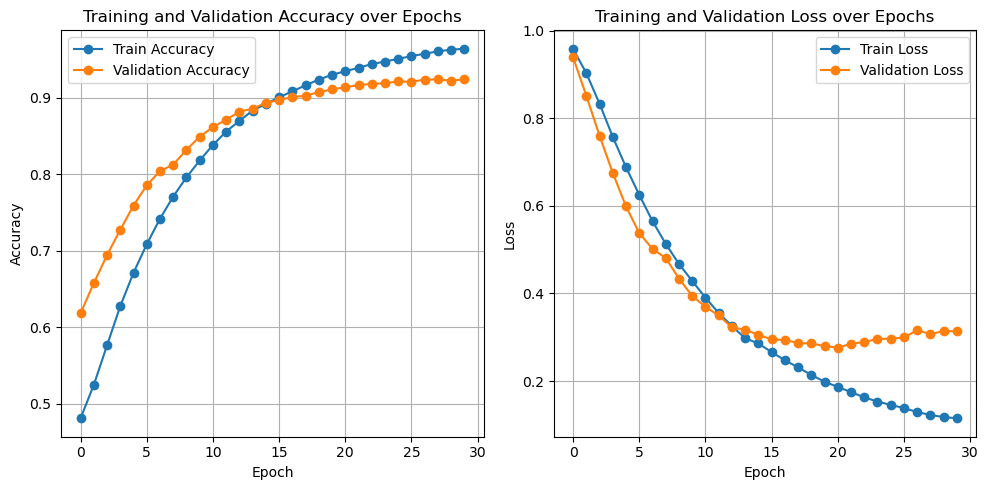

In [11]:
test_model_accuracy(model)

## Different Approach 
### Tested with Average Pooling layers

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D,GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='tanh',return_sequences=True),
    BatchNormalization(),
   AveragePooling1D(pool_size=2),
    Dropout(0.25),

    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='tanh',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    LSTM(64, activation='tanh',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_12 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_13 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_2 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                      

In [13]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 47s 158ms/step - loss: 0.9111 - accuracy: 0.5259 - val_loss: 0.9281 - val_accuracy: 0.6347
Epoch 2/30
175/175 [==============================] - 28s 157ms/step - loss: 0.6478 - accuracy: 0.7273 - val_loss: 0.5070 - val_accuracy: 0.7906
Epoch 3/30
175/175 [==============================] - 27s 154ms/step - loss: 0.5093 - accuracy: 0.7970 - val_loss: 0.3953 - val_accuracy: 0.8438
Epoch 4/30
175/175 [==============================] - 27s 156ms/step - loss: 0.4368 - accuracy: 0.8295 - val_loss: 0.3269 - val_accuracy: 0.8670
Epoch 5/30
175/175 [==============================] - 28s 157ms/step - loss: 0.4065 - accuracy: 0.8422 - val_loss: 0.3537 - val_accuracy: 0.8817
Epoch 6/30
175/175 [==============================] - 27s 154ms/step - loss: 0.3528 - accuracy: 0.8672 - val_loss: 0.3126 - val_accuracy: 0.8881
Epoch 7/30
175/175 [==============================] - 27s 157ms/step - loss: 0.3317 - accuracy: 0.8734 - val_loss: 0.2852 - val_ac

110/110 [==============================] - 3s 25ms/step - loss: 0.3522 - accuracy: 0.9294
Test Accuracy: 92.9368%


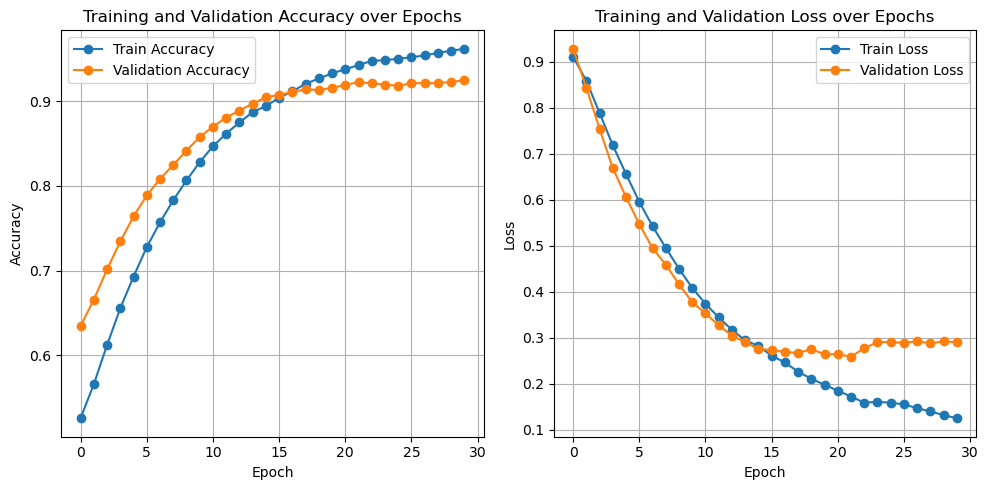

In [14]:
test_model_accuracy(model)

## Simple Model 

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, activation='tanh', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_20 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 dropout_25 (Dropout)        (None, 11, 256)           0         
                                                                 
 lstm_21 (LSTM)              (None, 128)               197120    
                                                                 
 batch_normalization_21 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_26 (Dropout)        (None, 128)              

In [20]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 21s 80ms/step - loss: 4.8056 - accuracy: 0.7824 - val_loss: 2.3082 - val_accuracy: 0.8628
Epoch 2/30
175/175 [==============================] - 13s 76ms/step - loss: 1.5789 - accuracy: 0.8517 - val_loss: 1.1064 - val_accuracy: 0.8717
Epoch 3/30
175/175 [==============================] - 15s 85ms/step - loss: 0.9448 - accuracy: 0.8629 - val_loss: 0.7498 - val_accuracy: 0.8674
Epoch 4/30
175/175 [==============================] - 19s 109ms/step - loss: 0.7045 - accuracy: 0.8626 - val_loss: 0.5703 - val_accuracy: 0.8849
Epoch 5/30
175/175 [==============================] - 15s 88ms/step - loss: 0.5850 - accuracy: 0.8704 - val_loss: 0.4803 - val_accuracy: 0.8853
Epoch 6/30
175/175 [==============================] - 15s 87ms/step - loss: 0.5273 - accuracy: 0.8700 - val_loss: 0.4847 - val_accuracy: 0.8785
Epoch 7/30
175/175 [==============================] - 15s 87ms/step - loss: 0.5157 - accuracy: 0.8661 - val_loss: 0.4531 - val_accuracy

110/110 [==============================] - 2s 20ms/step - loss: 0.3720 - accuracy: 0.8893
Test Accuracy: 88.9334%


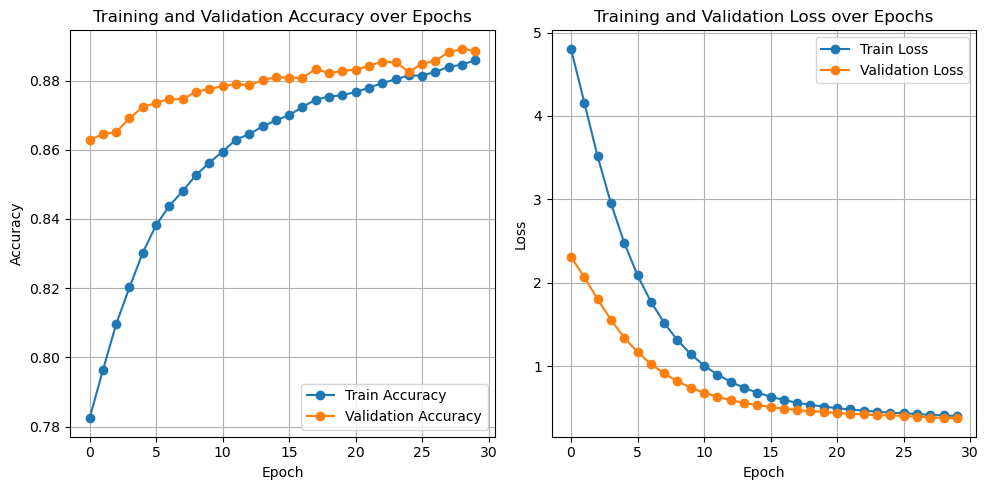

In [21]:
test_model_accuracy(model)

## Additional Test

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, GlobalAveragePooling1D, AveragePooling1D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(1e-5)),
    BatchNormalization(),
    LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(1e-5)),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer=l2(1e-5)),
    BatchNormalization(),
    LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer=l2(1e-5)),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=l2(1e-5)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-5)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-5)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 11, 64)            32256     
                                                                 
 batch_normalization_26 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 lstm_27 (LSTM)              (None, 11, 64)            33024     
                                                                 
 batch_normalization_27 (Bat  (None, 11, 64)           256       
 chNormalization)                                                
                                                                 
 average_pooling1d_5 (Averag  (None, 5, 64)            0         
 ePooling1D)                                                     
                                                      

In [26]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 25s 63ms/step - loss: 0.8636 - accuracy: 0.5732 - val_loss: 0.7749 - val_accuracy: 0.7702
Epoch 2/30
175/175 [==============================] - 6s 33ms/step - loss: 0.5052 - accuracy: 0.8069 - val_loss: 0.3605 - val_accuracy: 0.8585
Epoch 3/30
175/175 [==============================] - 8s 44ms/step - loss: 0.4016 - accuracy: 0.8491 - val_loss: 0.3128 - val_accuracy: 0.8656
Epoch 4/30
175/175 [==============================] - 7s 41ms/step - loss: 0.3517 - accuracy: 0.8683 - val_loss: 0.2964 - val_accuracy: 0.8774
Epoch 5/30
175/175 [==============================] - 7s 42ms/step - loss: 0.3202 - accuracy: 0.8765 - val_loss: 0.2619 - val_accuracy: 0.8921
Epoch 6/30
175/175 [==============================] - 7s 43ms/step - loss: 0.2940 - accuracy: 0.8911 - val_loss: 0.2631 - val_accuracy: 0.8939
Epoch 7/30
175/175 [==============================] - 7s 41ms/step - loss: 0.2698 - accuracy: 0.8982 - val_loss: 0.2863 - val_accuracy: 0.892

110/110 [==============================] - 1s 11ms/step - loss: 0.4464 - accuracy: 0.9245
Test Accuracy: 92.4507%


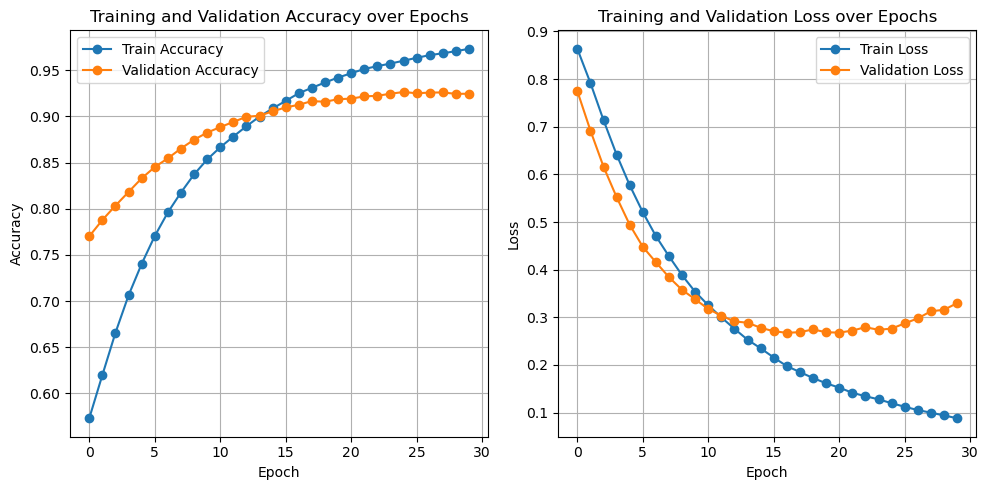

In [27]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers
### Testing with Different Activation Functions

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.25),
    
    LSTM(128, activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.25),
    
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_30 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_31 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_31 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_6 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                      

In [29]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 38s 155ms/step - loss: 0.8493 - accuracy: 0.6073 - val_loss: 1.0608 - val_accuracy: 0.3949
Epoch 2/30
175/175 [==============================] - 30s 169ms/step - loss: 0.5540 - accuracy: 0.8030 - val_loss: 0.6799 - val_accuracy: 0.7166
Epoch 3/30
175/175 [==============================] - 27s 157ms/step - loss: 0.4499 - accuracy: 0.8408 - val_loss: 0.4640 - val_accuracy: 0.8499
Epoch 4/30
175/175 [==============================] - 26s 147ms/step - loss: 0.3786 - accuracy: 0.8691 - val_loss: 0.3013 - val_accuracy: 0.8949
Epoch 5/30
175/175 [==============================] - 27s 152ms/step - loss: 0.3296 - accuracy: 0.8861 - val_loss: 0.3608 - val_accuracy: 0.8599
Epoch 6/30
175/175 [==============================] - 26s 147ms/step - loss: 0.3009 - accuracy: 0.8987 - val_loss: 0.3646 - val_accuracy: 0.8695
Epoch 7/30
175/175 [==============================] - 26s 149ms/step - loss: 0.2786 - accuracy: 0.9057 - val_loss: 0.2065 - val_ac

110/110 [==============================] - 3s 27ms/step - loss: 0.2191 - accuracy: 0.9477
Test Accuracy: 94.7669%


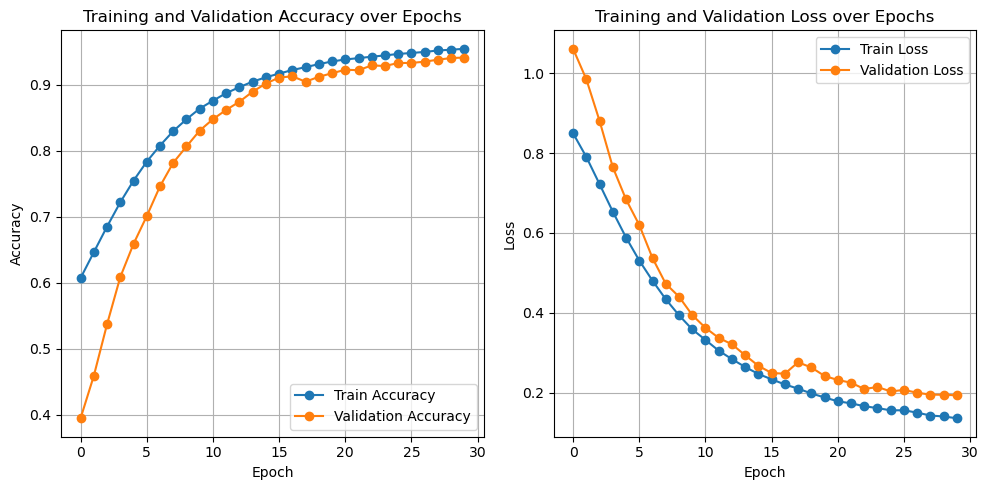

In [30]:
test_model_accuracy(model)

## Tweaked Model with Sigmoid Function (Selected)

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_34 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_35 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_35 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_7 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                      

In [32]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 34s 145ms/step - loss: 0.6953 - accuracy: 0.6917 - val_loss: 1.1573 - val_accuracy: 0.2898
Epoch 2/30
175/175 [==============================] - 28s 161ms/step - loss: 0.4271 - accuracy: 0.8426 - val_loss: 0.8202 - val_accuracy: 0.5479
Epoch 3/30
175/175 [==============================] - 26s 148ms/step - loss: 0.3849 - accuracy: 0.8637 - val_loss: 0.3343 - val_accuracy: 0.8721
Epoch 4/30
175/175 [==============================] - 27s 153ms/step - loss: 0.3312 - accuracy: 0.8805 - val_loss: 1.8779 - val_accuracy: 0.7034
Epoch 5/30
175/175 [==============================] - 26s 149ms/step - loss: 0.3008 - accuracy: 0.8932 - val_loss: 0.2920 - val_accuracy: 0.8735
Epoch 6/30
175/175 [==============================] - 26s 147ms/step - loss: 0.2670 - accuracy: 0.9055 - val_loss: 0.5216 - val_accuracy: 0.8292
Epoch 7/30
175/175 [==============================] - 27s 154ms/step - loss: 0.2496 - accuracy: 0.9132 - val_loss: 0.2002 - val_ac

110/110 [==============================] - 3s 31ms/step - loss: 0.1486 - accuracy: 0.9534
Test Accuracy: 95.3389%


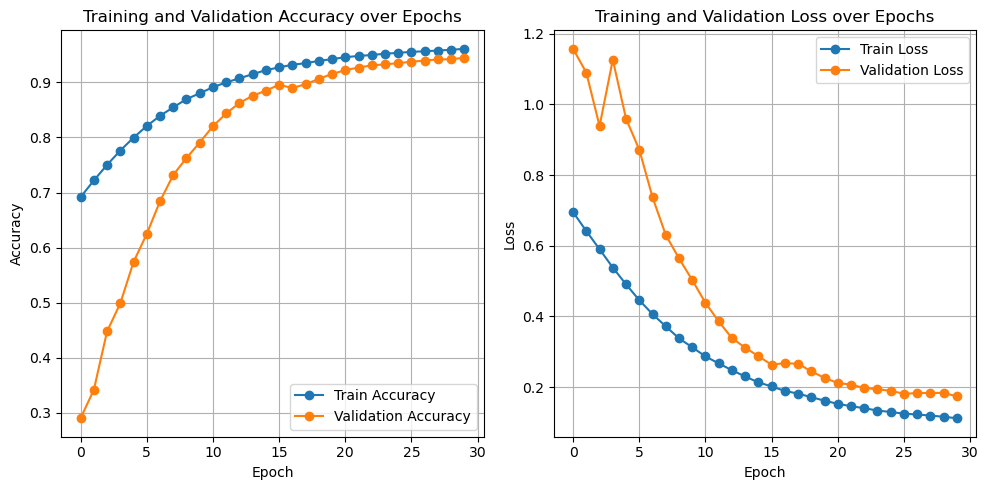

In [33]:
test_model_accuracy(model)

## Selected Model Complex Model with Average Pooling Layers
### Changing Learning Rate to 0.002

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_38 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_39 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_39 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_8 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                      

In [35]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 41s 167ms/step - loss: 0.6836 - accuracy: 0.6996 - val_loss: 1.1683 - val_accuracy: 0.3213
Epoch 2/30
175/175 [==============================] - 35s 202ms/step - loss: 0.4202 - accuracy: 0.8501 - val_loss: 0.4835 - val_accuracy: 0.8481
Epoch 3/30
175/175 [==============================] - 34s 192ms/step - loss: 0.3478 - accuracy: 0.8761 - val_loss: 0.2714 - val_accuracy: 0.8953
Epoch 4/30
175/175 [==============================] - 33s 189ms/step - loss: 0.2891 - accuracy: 0.8964 - val_loss: 0.6553 - val_accuracy: 0.7559
Epoch 5/30
175/175 [==============================] - 35s 201ms/step - loss: 0.2622 - accuracy: 0.9092 - val_loss: 0.3281 - val_accuracy: 0.8767
Epoch 6/30
175/175 [==============================] - 33s 188ms/step - loss: 0.2397 - accuracy: 0.9165 - val_loss: 0.2402 - val_accuracy: 0.9128
Epoch 7/30
175/175 [==============================] - 33s 191ms/step - loss: 0.2218 - accuracy: 0.9222 - val_loss: 0.3845 - val_ac

110/110 [==============================] - 4s 35ms/step - loss: 0.1956 - accuracy: 0.9514
Test Accuracy: 95.1387%


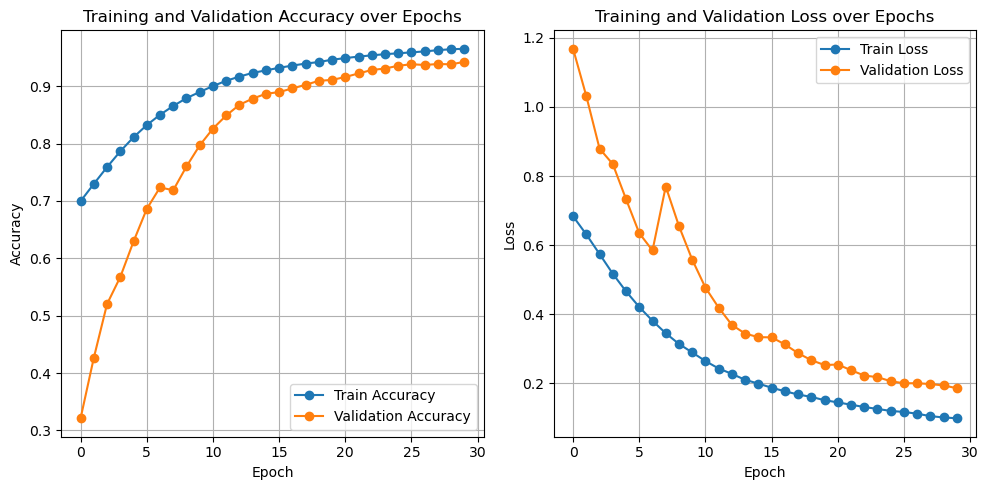

In [37]:
test_model_accuracy(model)

### Changing Learning Rate to 0.0005

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_42 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_43 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_43 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_9 (Averag  (None, 5, 256)           0         
 ePooling1D)                                                     
                                                     

In [39]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 38s 157ms/step - loss: 0.7761 - accuracy: 0.6395 - val_loss: 1.1218 - val_accuracy: 0.2898
Epoch 2/30
175/175 [==============================] - 26s 148ms/step - loss: 0.5194 - accuracy: 0.8136 - val_loss: 0.8413 - val_accuracy: 0.6680
Epoch 3/30
175/175 [==============================] - 27s 156ms/step - loss: 0.4318 - accuracy: 0.8472 - val_loss: 0.4662 - val_accuracy: 0.8227
Epoch 4/30
175/175 [==============================] - 27s 155ms/step - loss: 0.3898 - accuracy: 0.8607 - val_loss: 0.3367 - val_accuracy: 0.8595
Epoch 5/30
175/175 [==============================] - 34s 193ms/step - loss: 0.3471 - accuracy: 0.8758 - val_loss: 0.3767 - val_accuracy: 0.8474
Epoch 6/30
175/175 [==============================] - 29s 164ms/step - loss: 0.3177 - accuracy: 0.8844 - val_loss: 0.2686 - val_accuracy: 0.8989
Epoch 7/30
175/175 [==============================] - 29s 167ms/step - loss: 0.2887 - accuracy: 0.8991 - val_loss: 0.2696 - val_ac

110/110 [==============================] - 3s 31ms/step - loss: 0.2389 - accuracy: 0.9359
Test Accuracy: 93.5945%


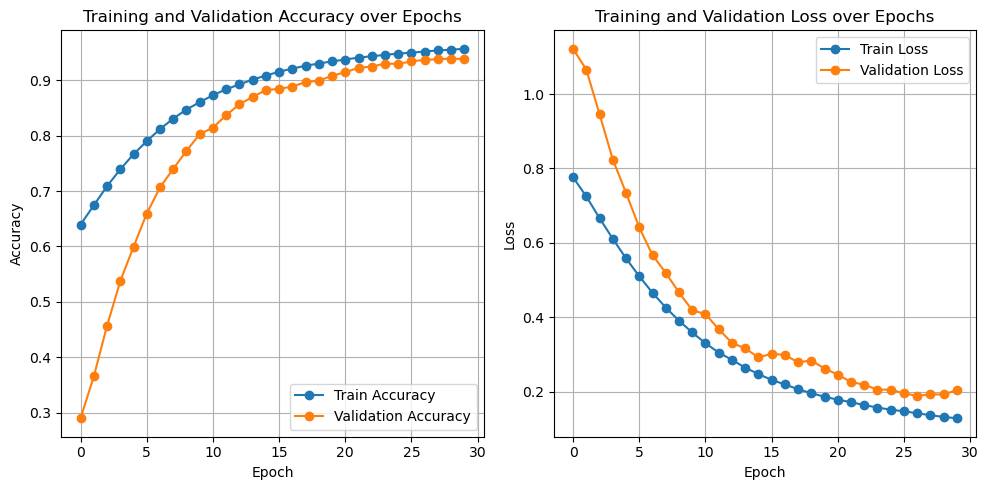

In [40]:
test_model_accuracy(model)

### Changing Learning Rate to 0.0015

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_78 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_79 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_79 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_18 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [67]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 48s 143ms/step - loss: 0.6680 - accuracy: 0.7187 - val_loss: 1.1258 - val_accuracy: 0.3728
Epoch 2/30
175/175 [==============================] - 27s 152ms/step - loss: 0.4477 - accuracy: 0.8447 - val_loss: 0.5322 - val_accuracy: 0.7845
Epoch 3/30
175/175 [==============================] - 26s 151ms/step - loss: 0.3628 - accuracy: 0.8720 - val_loss: 1.1038 - val_accuracy: 0.6526
Epoch 4/30
175/175 [==============================] - 27s 156ms/step - loss: 0.3127 - accuracy: 0.8881 - val_loss: 0.3640 - val_accuracy: 0.8367
Epoch 5/30
175/175 [==============================] - 29s 163ms/step - loss: 0.2781 - accuracy: 0.9026 - val_loss: 0.2467 - val_accuracy: 0.8981
Epoch 6/30
175/175 [==============================] - 29s 168ms/step - loss: 0.2432 - accuracy: 0.9144 - val_loss: 0.2097 - val_accuracy: 0.9199
Epoch 7/30
175/175 [==============================] - 27s 153ms/step - loss: 0.2246 - accuracy: 0.9202 - val_loss: 0.1888 - val_ac

110/110 [==============================] - 4s 32ms/step - loss: 0.1714 - accuracy: 0.9511
Test Accuracy: 95.1101%


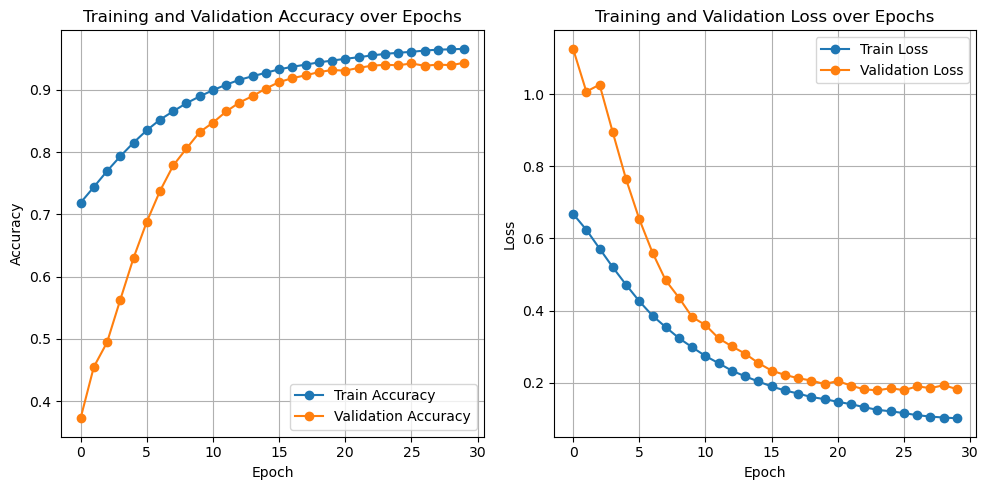

In [68]:
test_model_accuracy(model)

### Changing Learning Rate to 0.00125 (Selected)

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00125),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_82 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_83 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_83 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_19 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [70]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 39s 164ms/step - loss: 0.6667 - accuracy: 0.7183 - val_loss: 1.2051 - val_accuracy: 0.3213
Epoch 2/30
175/175 [==============================] - 27s 152ms/step - loss: 0.4417 - accuracy: 0.8444 - val_loss: 0.7886 - val_accuracy: 0.6369
Epoch 3/30
175/175 [==============================] - 27s 153ms/step - loss: 0.3761 - accuracy: 0.8682 - val_loss: 0.4390 - val_accuracy: 0.8317
Epoch 4/30
175/175 [==============================] - 27s 157ms/step - loss: 0.3312 - accuracy: 0.8839 - val_loss: 0.2835 - val_accuracy: 0.8863
Epoch 5/30
175/175 [==============================] - 26s 151ms/step - loss: 0.2816 - accuracy: 0.9022 - val_loss: 0.3935 - val_accuracy: 0.8638
Epoch 6/30
175/175 [==============================] - 27s 155ms/step - loss: 0.2559 - accuracy: 0.9108 - val_loss: 0.2558 - val_accuracy: 0.8978
Epoch 7/30
175/175 [==============================] - 28s 163ms/step - loss: 0.2272 - accuracy: 0.9215 - val_loss: 0.2404 - val_ac

110/110 [==============================] - 4s 35ms/step - loss: 0.1796 - accuracy: 0.9534
Test Accuracy: 95.3389%


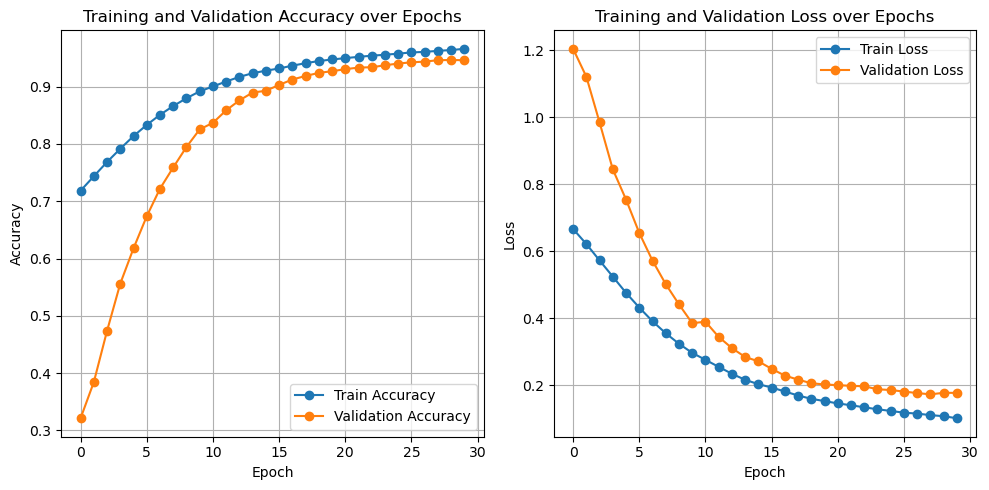

In [71]:
test_model_accuracy(model)

### Changing the Epsilon Value 2e-07

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=2e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_46 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_47 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_47 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_10 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [42]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 39s 147ms/step - loss: 0.7432 - accuracy: 0.6615 - val_loss: 1.1425 - val_accuracy: 0.4725
Epoch 2/30
175/175 [==============================] - 25s 145ms/step - loss: 0.4678 - accuracy: 0.8290 - val_loss: 0.7209 - val_accuracy: 0.7216
Epoch 3/30
175/175 [==============================] - 32s 186ms/step - loss: 0.3762 - accuracy: 0.8651 - val_loss: 0.4871 - val_accuracy: 0.7916
Epoch 4/30
175/175 [==============================] - 28s 162ms/step - loss: 0.3439 - accuracy: 0.8789 - val_loss: 0.2661 - val_accuracy: 0.8978
Epoch 5/30
175/175 [==============================] - 28s 159ms/step - loss: 0.3112 - accuracy: 0.8869 - val_loss: 0.3616 - val_accuracy: 0.8528
Epoch 6/30
175/175 [==============================] - 27s 152ms/step - loss: 0.2683 - accuracy: 0.9061 - val_loss: 0.3843 - val_accuracy: 0.8488
Epoch 7/30
175/175 [==============================] - 28s 157ms/step - loss: 0.2422 - accuracy: 0.9153 - val_loss: 0.2610 - val_ac

110/110 [==============================] - 4s 39ms/step - loss: 0.1784 - accuracy: 0.9442
Test Accuracy: 94.4238%


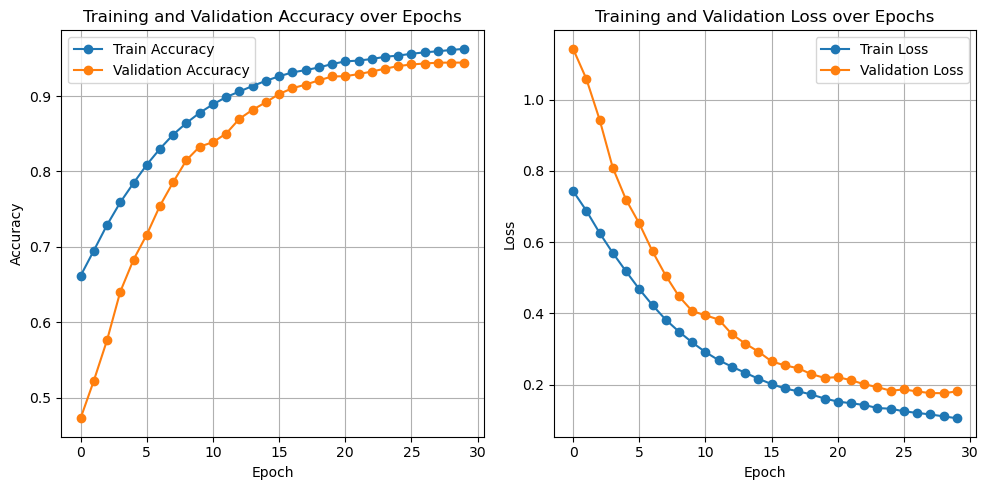

In [43]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.5e-07

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.5e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_50 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_51 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_51 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_11 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [45]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 38s 159ms/step - loss: 0.7304 - accuracy: 0.6720 - val_loss: 1.0452 - val_accuracy: 0.5218
Epoch 2/30
175/175 [==============================] - 26s 147ms/step - loss: 0.4638 - accuracy: 0.8323 - val_loss: 0.6873 - val_accuracy: 0.6637
Epoch 3/30
175/175 [==============================] - 27s 155ms/step - loss: 0.3959 - accuracy: 0.8604 - val_loss: 0.3519 - val_accuracy: 0.8645
Epoch 4/30
175/175 [==============================] - 26s 151ms/step - loss: 0.3383 - accuracy: 0.8774 - val_loss: 0.3636 - val_accuracy: 0.8624
Epoch 5/30
175/175 [==============================] - 26s 149ms/step - loss: 0.2991 - accuracy: 0.8949 - val_loss: 0.4415 - val_accuracy: 0.8517
Epoch 6/30
175/175 [==============================] - 28s 158ms/step - loss: 0.2641 - accuracy: 0.9022 - val_loss: 0.4126 - val_accuracy: 0.8395
Epoch 7/30
175/175 [==============================] - 27s 152ms/step - loss: 0.2473 - accuracy: 0.9153 - val_loss: 0.2116 - val_ac

110/110 [==============================] - 4s 37ms/step - loss: 0.2108 - accuracy: 0.9494
Test Accuracy: 94.9385%


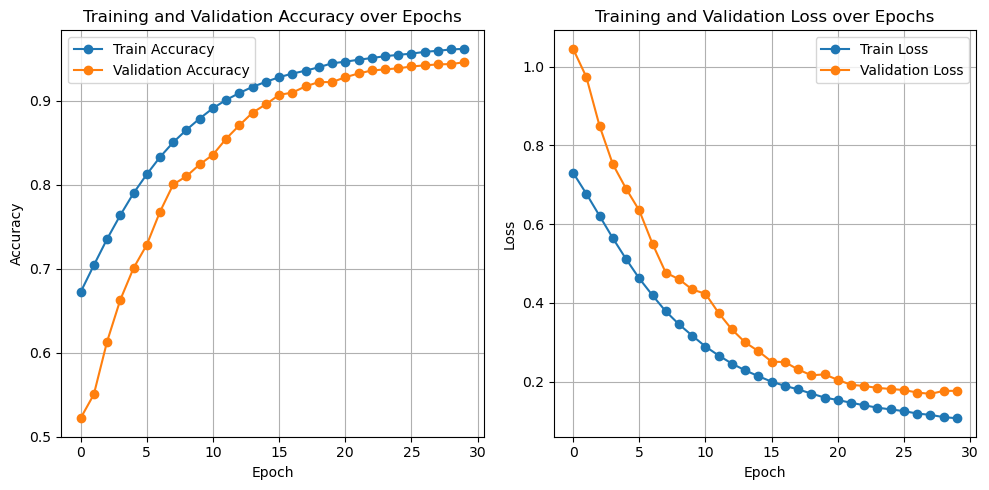

In [46]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.75e-07

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.75e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_62 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_63 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_63 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_14 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [55]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 35s 144ms/step - loss: 0.7794 - accuracy: 0.6409 - val_loss: 1.0969 - val_accuracy: 0.3427
Epoch 2/30
175/175 [==============================] - 28s 160ms/step - loss: 0.4888 - accuracy: 0.8311 - val_loss: 0.5814 - val_accuracy: 0.7931
Epoch 3/30
175/175 [==============================] - 26s 151ms/step - loss: 0.4095 - accuracy: 0.8574 - val_loss: 0.3387 - val_accuracy: 0.8581
Epoch 4/30
175/175 [==============================] - 26s 151ms/step - loss: 0.3367 - accuracy: 0.8811 - val_loss: 0.8326 - val_accuracy: 0.6923
Epoch 5/30
175/175 [==============================] - 27s 153ms/step - loss: 0.2906 - accuracy: 0.8987 - val_loss: 0.2415 - val_accuracy: 0.9103
Epoch 6/30
175/175 [==============================] - 27s 153ms/step - loss: 0.2636 - accuracy: 0.9080 - val_loss: 0.5828 - val_accuracy: 0.8134
Epoch 7/30
175/175 [==============================] - 26s 151ms/step - loss: 0.2552 - accuracy: 0.9099 - val_loss: 0.2574 - val_ac

110/110 [==============================] - 4s 37ms/step - loss: 0.2008 - accuracy: 0.9434
Test Accuracy: 94.3380%


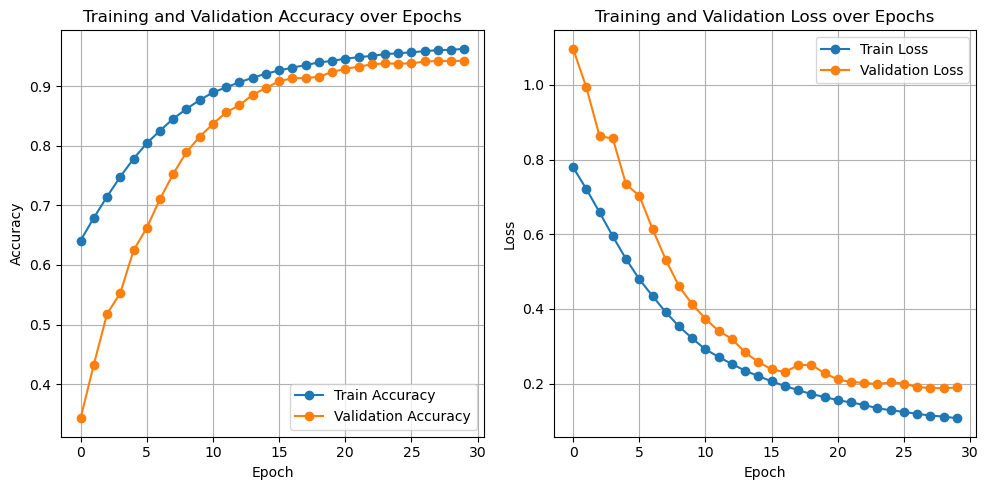

In [56]:
test_model_accuracy(model)

### Changing the Epsilon Value 0.9e-07

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=0.9e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_70 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_71 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_71 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_16 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [61]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 45s 144ms/step - loss: 0.7006 - accuracy: 0.7023 - val_loss: 1.1411 - val_accuracy: 0.3149
Epoch 2/30
175/175 [==============================] - 26s 146ms/step - loss: 0.4542 - accuracy: 0.8395 - val_loss: 0.5606 - val_accuracy: 0.7770
Epoch 3/30
175/175 [==============================] - 27s 154ms/step - loss: 0.3827 - accuracy: 0.8630 - val_loss: 0.2874 - val_accuracy: 0.8903
Epoch 4/30
175/175 [==============================] - 26s 148ms/step - loss: 0.3354 - accuracy: 0.8797 - val_loss: 0.4655 - val_accuracy: 0.8099
Epoch 5/30
175/175 [==============================] - 27s 152ms/step - loss: 0.3071 - accuracy: 0.8922 - val_loss: 0.2482 - val_accuracy: 0.9142
Epoch 6/30
175/175 [==============================] - 26s 151ms/step - loss: 0.2768 - accuracy: 0.9045 - val_loss: 0.2915 - val_accuracy: 0.8921
Epoch 7/30
175/175 [==============================] - 26s 148ms/step - loss: 0.2338 - accuracy: 0.9182 - val_loss: 0.3455 - val_ac

110/110 [==============================] - 4s 38ms/step - loss: 0.1842 - accuracy: 0.9468
Test Accuracy: 94.6812%


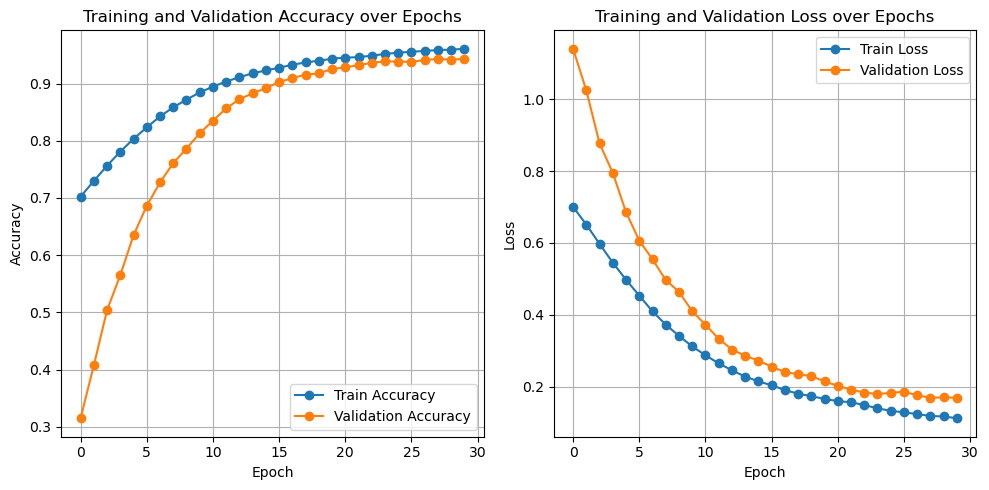

In [62]:
test_model_accuracy(model)

### Changing the Epsilon Value 1.2e-07

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=1.2e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_74 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_75 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_75 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_17 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [64]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 35s 136ms/step - loss: 0.7614 - accuracy: 0.6625 - val_loss: 1.0772 - val_accuracy: 0.4682
Epoch 2/30
175/175 [==============================] - 26s 151ms/step - loss: 0.4675 - accuracy: 0.8337 - val_loss: 0.5526 - val_accuracy: 0.8142
Epoch 3/30
175/175 [==============================] - 26s 150ms/step - loss: 0.3881 - accuracy: 0.8641 - val_loss: 0.4484 - val_accuracy: 0.8059
Epoch 4/30
175/175 [==============================] - 26s 148ms/step - loss: 0.3297 - accuracy: 0.8818 - val_loss: 0.2537 - val_accuracy: 0.8996
Epoch 5/30
175/175 [==============================] - 26s 149ms/step - loss: 0.2862 - accuracy: 0.8992 - val_loss: 0.3350 - val_accuracy: 0.8892
Epoch 6/30
175/175 [==============================] - 26s 151ms/step - loss: 0.2497 - accuracy: 0.9103 - val_loss: 0.2120 - val_accuracy: 0.9267
Epoch 7/30
175/175 [==============================] - 26s 147ms/step - loss: 0.2381 - accuracy: 0.9162 - val_loss: 0.2784 - val_ac

110/110 [==============================] - 3s 27ms/step - loss: 0.1862 - accuracy: 0.9497
Test Accuracy: 94.9671%


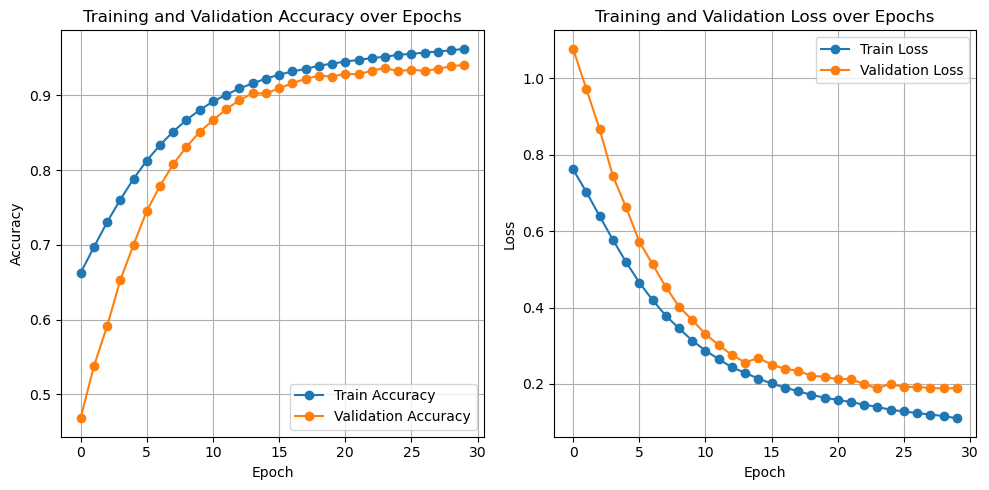

In [65]:
test_model_accuracy(model)

### Changing the Epsilon Value 2.5e-07

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001,epsilon=2.5e-07),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_66 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_67 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_67 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_15 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [58]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 41s 140ms/step - loss: 0.7014 - accuracy: 0.7029 - val_loss: 1.2021 - val_accuracy: 0.3231
Epoch 2/30
175/175 [==============================] - 25s 143ms/step - loss: 0.4507 - accuracy: 0.8409 - val_loss: 0.5969 - val_accuracy: 0.8131
Epoch 3/30
175/175 [==============================] - 27s 154ms/step - loss: 0.3955 - accuracy: 0.8655 - val_loss: 0.4215 - val_accuracy: 0.8238
Epoch 4/30
175/175 [==============================] - 29s 165ms/step - loss: 0.3530 - accuracy: 0.8772 - val_loss: 0.3211 - val_accuracy: 0.8806
Epoch 5/30
175/175 [==============================] - 26s 150ms/step - loss: 0.2924 - accuracy: 0.8914 - val_loss: 0.2676 - val_accuracy: 0.8981
Epoch 6/30
175/175 [==============================] - 26s 151ms/step - loss: 0.2887 - accuracy: 0.9012 - val_loss: 0.2113 - val_accuracy: 0.9178
Epoch 7/30
175/175 [==============================] - 26s 148ms/step - loss: 0.2420 - accuracy: 0.9113 - val_loss: 0.2697 - val_ac

110/110 [==============================] - 3s 29ms/step - loss: 0.1837 - accuracy: 0.9405
Test Accuracy: 94.0520%


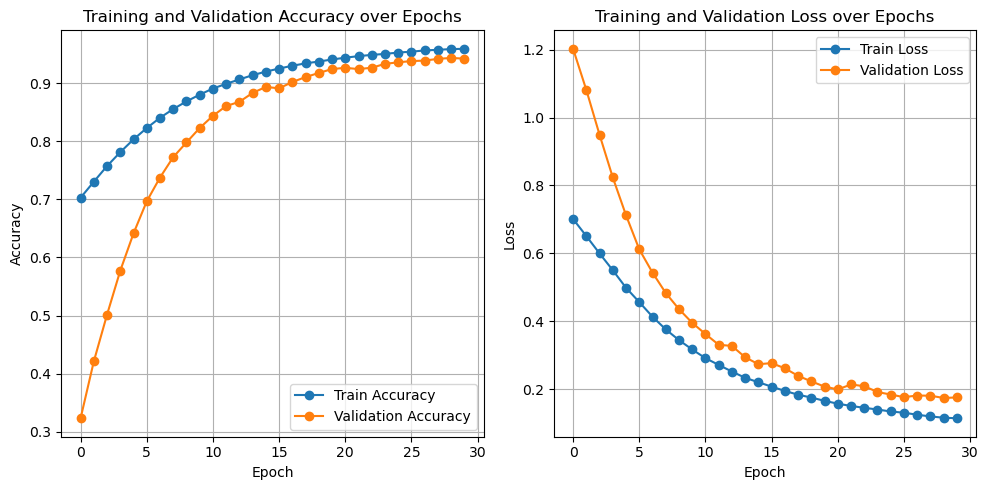

In [59]:
test_model_accuracy(model)

## Testing with SGD Optimizer

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


optimizer = SGD(learning_rate=0.01)
# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_54 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_55 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_55 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_12 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [49]:
history = model.fit(x_train_lstm, y_train_lstm, epochs=30, validation_split=0.2, batch_size=64)

Epoch 1/30
175/175 [==============================] - 32s 137ms/step - loss: 0.9870 - accuracy: 0.4587 - val_loss: 1.1165 - val_accuracy: 0.2898
Epoch 2/30
175/175 [==============================] - 25s 144ms/step - loss: 0.8494 - accuracy: 0.6139 - val_loss: 1.1259 - val_accuracy: 0.3731
Epoch 3/30
175/175 [==============================] - 26s 149ms/step - loss: 0.7223 - accuracy: 0.7149 - val_loss: 0.7113 - val_accuracy: 0.7691
Epoch 4/30
175/175 [==============================] - 27s 154ms/step - loss: 0.6239 - accuracy: 0.7717 - val_loss: 0.4747 - val_accuracy: 0.8442
Epoch 5/30
175/175 [==============================] - 25s 144ms/step - loss: 0.5817 - accuracy: 0.7938 - val_loss: 0.4210 - val_accuracy: 0.8581
Epoch 6/30
175/175 [==============================] - 27s 153ms/step - loss: 0.5414 - accuracy: 0.8104 - val_loss: 0.3972 - val_accuracy: 0.8674
Epoch 7/30
175/175 [==============================] - 25s 146ms/step - loss: 0.5155 - accuracy: 0.8205 - val_loss: 0.3686 - val_ac

110/110 [==============================] - 3s 26ms/step - loss: 0.3307 - accuracy: 0.8882
Test Accuracy: 88.8190%


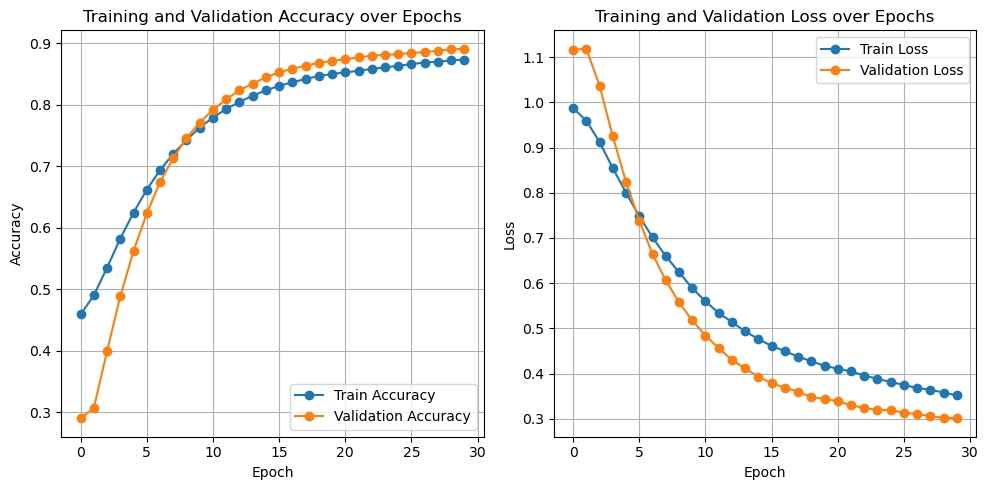

In [50]:
test_model_accuracy(model)

## Implementing Early Stopping

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input,LSTM,GlobalAveragePooling1D, TimeDistributed, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

samples, time_steps, features = x_train_lstm.shape
num_classes = y_train_lstm.shape[1]

# Create the model
model = Sequential([
    Input(shape=(time_steps, features)),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(256, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    AveragePooling1D(pool_size=2),
    Dropout(0.3),
    
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    LSTM(128, activation='sigmoid',recurrent_activation='sigmoid',return_sequences=True),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 11, 256)           325632    
                                                                 
 batch_normalization_58 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 lstm_59 (LSTM)              (None, 11, 256)           525312    
                                                                 
 batch_normalization_59 (Bat  (None, 11, 256)          1024      
 chNormalization)                                                
                                                                 
 average_pooling1d_13 (Avera  (None, 5, 256)           0         
 gePooling1D)                                                    
                                                     

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  #Monitor validation loss
    patience=5,          #Number of epochs with no improvement after which training will be stopped
    min_delta=0.01,      #Minimum change to qualify as an improvement
    mode='min',          #The training will stop when the quantity monitored stops decreasing
    verbose=1            #Print messages when early stopping is triggered
)

# Testing with high number of epochs
history = model.fit(x_train_lstm, y_train_lstm, epochs=50, validation_split=0.2,batch_size=64, callbacks=[early_stopping])

Epoch 1/50
175/175 [==============================] - 39s 164ms/step - loss: 0.7387 - accuracy: 0.6563 - val_loss: 1.1222 - val_accuracy: 0.3660
Epoch 2/50
175/175 [==============================] - 26s 151ms/step - loss: 0.4632 - accuracy: 0.8377 - val_loss: 0.6266 - val_accuracy: 0.7852
Epoch 3/50
175/175 [==============================] - 27s 154ms/step - loss: 0.3841 - accuracy: 0.8648 - val_loss: 0.4359 - val_accuracy: 0.8238
Epoch 4/50
175/175 [==============================] - 26s 150ms/step - loss: 0.3458 - accuracy: 0.8744 - val_loss: 0.2959 - val_accuracy: 0.8756
Epoch 5/50
175/175 [==============================] - 27s 154ms/step - loss: 0.2862 - accuracy: 0.8953 - val_loss: 0.3794 - val_accuracy: 0.8324
Epoch 6/50
175/175 [==============================] - 27s 156ms/step - loss: 0.2649 - accuracy: 0.9037 - val_loss: 0.2627 - val_accuracy: 0.8956
Epoch 7/50
175/175 [==============================] - 27s 152ms/step - loss: 0.2435 - accuracy: 0.9114 - val_loss: 0.2233 - val_ac

110/110 [==============================] - 3s 30ms/step - loss: 0.1892 - accuracy: 0.9302
Test Accuracy: 93.0226%


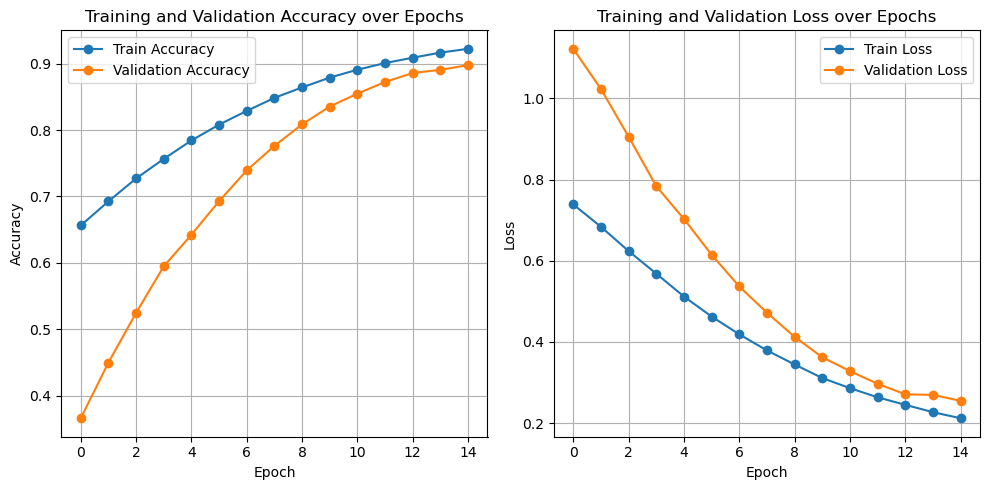

In [53]:
test_model_accuracy(model)